# Monte-Carlo-Simulation einer Bremer Steuerreform

## 1. Einführung

Dieses Notebook ist der online Appendix zu der Analyse **"Monte-Carlo-Simulation einer Bremer Steuerreform: Effizienz- und Verteilungswirkungen einer Umschichtung von Grunderwerbsteuer und Gewerbesteuer in die Grundsteuer"**. Die Analyse selbst ist als PDF auf meinem GitHub verfügbar [(Link)](https://github.com/max-oppermann/Public_repository/tree/master/Monte%20Carlo%20Tax%20Reform); dieses Notebook enthält den vollständigen Python-Code der Simulation sowie technische Details zu den methodischen Entscheidungen, die in der Analyse nur konzeptuell beschrieben werden.  

Ein Jupyter Notebook ist ein interaktives Dokument, das Text, mathematische Formeln und ausführbaren Code in einer Datei vereint. Die grauen Zellen enthalten Python-Code; die weißen Zellen – wie diese hier – enthalten Erklärungen.

### Die Reform

Die Analyse untersucht eine aufkommensneutrale Steuerreform in Bremen, die 100 Millionen Euro aus der Grunderwerbsteuer und 500 Millionen Euro aus der Gewerbesteuer in die Grundsteuer umschichtet. Im Code werden die drei Steuern mit englischen Abkürzungen bezeichnet, die ihrer deutschen Entsprechung folgen:

- **PT** (*property tax*) – Grundsteuer
- **RETT** (*real estate transfer tax*) – Grunderwerbsteuer  
- **LBT** (*local business tax*) – Gewerbesteuer

### Aufbau des Notebooks

Das Notebook folgt der Struktur der Analyse:

1. **Einführung** – dieser Abschnitt
2. **DWL der Steuern** – Wahrscheinlichkeitsverteilungen für die 
   ökonomischen Kosten der drei Steuern
3. **Wachstumseffekte** – Modellierung des steuerinduzierten Wachstums
4. **Inzidenz der Steuern** – Verteilung der Steuerlasten über die 
   Einkommensdezile
5. **Inzidenz des DWL** – Verteilung der Effizienzgewinne
6. **Inzidenz des Wachstums** – Einkommensverteilung aus Bremer 
   Steuerdaten rekonstruiert
7. **Verteilungsgewichte** – Gewichte aus dem abnehmenden Grenznutzen 
   von Geld
8. **Simulation** – die eigentlichen 100.000 Simulationen
9. **Grafiken** – alle Abbildungen aus der Analyse und mehr

Das hier sind alle nötigen Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm, t, uniform
from scipy.interpolate import PchipInterpolator

Und hier lege ich einige Variablen fest:

In [2]:
rett_change = 100e+6
lbt_change = 500e+6
pt_change = -(rett_change + lbt_change)

# Löffler/Siegloch 2024
pt_DWL_mean = 0.04
pt_DWL_sd = 0.06

# from Buettner (2017), Table 2. These are about elasticities, not DWL directly
rett_DWL_mean = 0.569
rett_DWL_sd = 0.124
rett_DWL_df = 15
rett_target_rhos = np.array([0.5, 0.86]) # my pick, pt incidence explaining 1/4 and 3/4 of the variance in rett incidence, respectively

# dispersed over the literature, check text for details
lbt_DWL_mode = 1.6
lbt_DWL_lower = 1.1
lbt_DWL_upper =2.0

# https://www.statistikportal.de/de/vgrdl/ergebnisse-laenderebene/bruttoinlandsprodukt-bruttowertschoepfung/bip#9535
bremen_gdp = 42e+9
tax_reform_size = -pt_change / bremen_gdp
growth_duration = np.array([3, 6, 10])
# Alinaghi/Reed (2020):
growth_mean = 0.082
growth_sd = 0.031

# values oriented around Figure 6, Panel B in Löffler/Siegloch 2024
pt_incidence_means = np.array([0.1, 0.1, 0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1])
pt_incidence_sd = 0.1

# no clear data, hence four quite different scenarios and a larger standard deviation to reflect the uncertainty
lbt_incidence_means_regressive = np.ones(10) * -0.1
lbt_incidence_means_neutral = np.zeros(10)
lbt_incidence_means_inverse_pt = pt_incidence_means
lbt_incidence_means_progressive = lbt_incidence_means_regressive * -1.0
lbt_incidence_sd = 0.2

# 2. Den *deadweight loss* der Steuern zufällig ziehen  

Die Analyse beschreibt konzeptuell, welche Wahrscheinlichkeitsverteilungen 
für den DWL der drei Steuern angenommen werden und warum. Dieser Abschnitt 
implementiert diese Verteilungen in Code. Für jede der drei Steuern wird 
eine andere Verteilungsfamilie verwendet, da die verfügbare empirische 
Evidenz unterschiedlicher Art ist:

## 2.1. Grundsteuer

Löffler und Siegloch (2024) liefern direkt Daten für den DWL der 
Grundsteuer: Mittelwert 0,04 und Standardfehler 0,06. Da eine 
Normalverteilung negative DWL-Werte zulassen würde, verwende ich eine 
**abgeschnittene Normalverteilung** (*truncated normal*), die bei Null 
nach unten begrenzt ist. Die Funktion `draw_from_truncated_normal` 
implementiert das, indem sie die Grenzen in standardisierte 
Normalverteilungs-Einheiten umrechnet und dann mit `scipy.stats.truncnorm` 
zieht (die solche Standardisierung verlangt).

In [3]:
def draw_from_truncated_normal(mean, sd, lower_trunc=0.0, upper_trunc=np.inf, count=1) -> np.ndarray:
    # scipy uses standardized bounds: "truncated at a and b standard deviations from loc"
    # NOT truncated at lower_trunc and upper_trunc
    return truncnorm((lower_trunc - mean) / sd, (upper_trunc - mean) / sd, loc=mean, scale=sd).rvs(size=count)


## 2.2. Grunderwerbsteuer  

Hier liegen keine direkten DWL-Schätzer vor, sondern Elastizitäten der 
Steuereinnahmen aus Büttner (2017). Da die Grunderwerbsteuer eine 
Landessteuer ist und nur 16 Bundesländer als Beobachtungen vorliegen, 
folgen die Schätzer einer **$t$-Verteilung mit 15 Freiheitsgraden** – 
nicht einer Normalverteilung. Die Funktion `DWL_from_truncated_t_dist` 
implementiert die Umwandlung in zwei Schritten: Zunächst wird per 
Inversionsmethode eine zufällige Elastizität aus der $t$-Verteilung 
gezogen (begrenzt auf den Bereich 0,1 bis 1,0, um absurde Werte 
auszuschließen); dann wird die Elastizität $\varepsilon$ in einen DWL 
nach der Formel $\frac{1}{\varepsilon} - 1$ umgerechnet.

In [4]:
# df for "degrees of freedom," not DataFrame

def DWL_from_truncated_t_dist(df, mean, sd, lower_elasticity=0.1, upper_elasticity=1, count=1) -> np.ndarray:
    # convert bounds from paper to the standardized t-dist SDs
    alpha = (lower_elasticity - mean) / sd
    beta = (upper_elasticity - mean) / sd
    
    # find the CDF values at those bounds
    cdf_lower_elasticity = t.cdf(alpha, df)
    cdf_upper_elasticity = t.cdf(beta, df)
    
    # draw uniformly between those two CDF values
    # loc and scale are not mean and SD. They are the lower and upper bound, respectively.
    u = uniform.rvs(loc=cdf_lower_elasticity, scale=cdf_upper_elasticity - cdf_lower_elasticity, size=count)
    
    # use the inverse CDF to get the values back; that's the ppf part
    # this also converts elasticities to DWL like (1 / elasticity) - 1, like in the paper.
    return (1 / (t.ppf(u, df) * sd + mean)) - 1


## 2.3. Gewerbesteuer

Für die Gewerbesteuer gibt es keine direkt verwendbare Verteilung in 
der Literatur. Stattdessen werden mehrere Einzelschätzer aus 
verschiedenen Studien herangezogen, um eine plausible Bandbreite 
abzustecken (Details in der Analyse, Abschnitt 2.1.3). In solchen 
Situationen ist eine **Dreiecksverteilung** (*triangular distribution*) 
eine übliche Wahl: Sie erfordert nur drei Parameter – Untergrenze, 
Modalwert und Obergrenze – und macht keine stärkeren Annahmen über die 
Form der Verteilung. Die Funktion `DWL_from_triangular` zieht aus 
`numpy.random.triangular` und subtrahiert 1, um von der Steuerbasis-
Elastizität zum DWL zu gelangen.

In [5]:
def DWL_from_triangular(lower=lbt_DWL_lower, mode=lbt_DWL_mode, upper=lbt_DWL_upper, count=1) -> np.ndarray:
    return np.random.triangular(lower, mode, upper, size=count) - 1


# 3. Wachstums-Effekte simulieren

Die Funktion `generate_growth_effect` implementiert das Wachstumsmodell, 
das in Abschnitt 2.2 der Analyse beschrieben wird. Der Grundgedanke: 
Eine *TaxPositive* Reform im Ausmaß von `reform_size` Anteil des BIP 
erhöht das jährliche Wachstum um `reform_size` × $\mathcal{N}(0.082, 
0.031)$, wobei Mittelwert und Standardfehler aus 
Alinaghi und Reed (2021) stammen. Dieser Wachstumseffekt wird dann 
genutzt, um den kumulativen Niveaueffekt nach `duration` Jahren zu 
berechnen:

$$\text{BIP} \times (1 + \text{Wachstum})^{\text{Jahre}} - \text{BIP}$$

Zwei Modellierungsentscheidungen:

**Kein Hintergrundwachstum:** Die Funktion nimmt an, dass die Bremer 
Wirtschaft ohne die Reform weder wächst noch schrumpft. Das unterschätzt 
den Wachstumseffekt leicht, da steuerinduziertes Wachstum bei einer 
ohnehin wachsenden Wirtschaft größer ausfiele.

**Niveaueffekt, kein dauerhafter Wachstumseffekt:** Der zurückgegebene 
Wert ist kein einmaliger Gewinn, sondern ein dauerhafter jährlicher 
Niveaueffekt: Nach Ablauf des Wachstumszeitraums wächst Bremen wieder 
mit seiner üblichen Rate, aber von einer höheren Ausgangsbasis. Die 
Effekte *während* des Wachstumszeitraums werden vollständig 
vernachlässigt, was den Nutzen der Reform erneut eher zu klein rechnet. 

In [6]:
def generate_growth_effect(reform_size=0.0, starting_gdp=0.0, mean=0.082, sd=0.031, duration=5, count=1) -> np.ndarray:
    """Assumes that there would be 0 growth but for the tax reform.
    Args:
        reform_size: Amount of tax dollars moved as fraction of the tax base (usually just GDP). 
                     If the tax reform represents one percent of GDP, the parameter should be 0.01.
        starting_gdp: The GDP value to be used in the calculation of growth.
        mean: Average annual growth effect of a 1% (of GDP) tax reform. The default is from Alinaghi/Reed 2020.
        sd: The SE of the mean. The default is from the same source.
        duration: The number of years the induced growth will last.
        count: Number of draws to make.
    Returns:
        np.ndarray: The total growth effect in the input currency, as an array of length `count`.
    """
    # it's not actually a percentage, it's a decimal
    growth_percentage = reform_size * norm.rvs(loc=mean, scale=sd, size=count)
    return ((starting_gdp * (1 + growth_percentage)**duration) - starting_gdp)


# 4. Inzidenz der Steuern über die Dezile

Dieser Abschnitt implementiert zwei Funktionen, die zufällige 
Verteilungsvektoren über die zehn Einkommensdezile generieren. Beide 
geben einen normalisierten Vektor der Länge 10 zurück, dessen Einträge 
angeben, welcher Anteil einer Steuer auf welches Dezil fällt.

#### `piecewise_linear_incidence`

Diese Funktion wird für die Grundsteuer und die Gewerbesteuer verwendet, 
wo die unterliegende Inzidenzkurve entweder aus der Literatur bekannt 
ist (Grundsteuer) oder durch Szenarien festgelegt wird (Gewerbesteuer). 
Der Mechanismus in drei Schritten:

1. Für jedes Dezil wird ein zufälliger Parameter $\theta_d$ aus einer 
   Normalverteilung mit dem angegebenen `mean_vector` und `sd` gezogen.
2. Die kumulierte Summe der $\theta_d$ ergibt die Steigung der 
   Inzidenzkurve in jedem Dezil – technisch eine untere 
   Dreiecksmatrix-Multiplikation. So entsteht eine stückweise lineare, 
   zusammenhängende Kurve über die Dezile.
3. Der Vektor wird durch Exponentiation und anschließende Normalisierung 
   auf positive Werte gebracht, sodass die Einträge sich zu Eins 
   aufsummieren.

Das `mean_vector`-Argument bestimmt die durchschnittliche Form der 
Kurve: Ein Vektor mit negativen Werten für die unteren Dezile und 
positiven für die oberen erzeugt tendenziell eine regressive Kurve; 
ein Nullvektor eine neutrale.

#### `correlated_incidence`

Diese Funktion wird für die Grunderwerbsteuer verwendet, deren Inzidenz 
mit jener der Grundsteuer korreliert sein soll, sowie für die Inzidenz 
der DWLs, die stark mit der Inzidenz der jeweiligen Steuer korrelieren 
sollen. Sie generiert einen neuen Inzidenzvektor mit einer exakt 
vorgegebenen Korrelation `target_rho` zu einem bestehenden Vektor 
`original_incidence`.

Das geschieht durch ein Gram-Schmidt-Verfahren im Log-Raum:

1. Der ursprüngliche Vektor wird logarithmiert, um negative Werte zu 
   vermeiden.
2. Ein zufälliger Rauschvektor wird orthogonal zum ursprünglichen 
   Vektor gemacht – er enthält also nur Information, die *nicht* im 
   Original steckt.
3. Beide normalisierten Vektoren werden mit den Gewichten `target_rho` 
   und $\sqrt{1 - \rho^2}$ gemischt, was geometrisch eine exakte 
   Korrelation von `target_rho` garantiert.
4. Der resultierende Vektor wird rücktransformiert und normalisiert.

In [7]:
# this one is for the property tax and the lbt

def piecewise_linear_incidence(sd=1.0, mean_vector=np.zeros(10)) -> np.ndarray:
    """ Generates a piecewise linear curve across deciles with the value in each decile drawn randomly.
        That will draw out some kind of connected curve. That curve in turn is scaled so that the values sum to 1.
    Args:
        sd: SD of the distribution the incremental slopes are drawn from.
        mean_vector: Mean of the distribution the incremental slopes are drawn from.
                     Length 10 to default to deciles.
    Returns:
        np.ndarray: An array with a weight for each decile, corresponding to how much of a tax the decile bears.
    """
    # incremental slope parameters
    theta = np.random.normal(mean_vector, sd)

    # final slopes in each decile
    slopes = np.tril(np.ones((len(mean_vector), len(mean_vector)))) @ theta
    
    # normalize in the return
    temp = np.exp(slopes)
    return temp / temp.sum()

In [8]:
# this one is for the rett and for drawing the DWL incidence

def correlated_incidence(original_incidence: np.ndarray = np.zeros(10), target_rho=0.0, match_moments=True) -> np.ndarray:
    """ Also generates a vector of incidences, but with a specific correlation to another such vector. 
        This is for the rett, which I want to be correlated with the property tax, and for the DWL incidence, 
        which I want to be correlated with the tax incidence.
    Args:
        original_incidence: Incidence vector that the new one will be correlated with.
        target_rho: How much the new and old vector should correlate.
        match_moments: If True, the new vector will have the same mean and standard deviation as the original.
    Returns:
        np.ndarray: A new incidence vector with the specified correlation to the original.
    """
    length = len(original_incidence)
    x = original_incidence.copy()
    
    # log to avoid negatives, tiny epsilon to avoid log(0)
    x_working = np.log(x + 1e-9)
    x_mean = np.mean(x_working)
    x_centered = x_working - x_mean
    
    # add random noise orthogonal to x_centered (Gram-Schmidt)
    r = np.random.randn(length)
    r_orthogonal = r - (np.dot(r, x_centered) / np.dot(x_centered, x_centered)) * x_centered
    
    # normalize to make the correlation work (which is normalized)
    x_norm = x_centered / np.linalg.norm(x_centered)
    r_norm = r_orthogonal / np.linalg.norm(r_orthogonal)
    
    # mix vectors to achieve exact target correlation
    y_norm = (target_rho * x_norm) + (np.sqrt(1 - target_rho**2) * r_norm)
    
    # rescale to match property tax
    if match_moments:
        desired_std = np.std(x_working)
        desired_mean = x_mean
    else:
        # default to standard normal if not matching moments
        desired_std = 1.0
        desired_mean = 0.0
    
    # this is a location–scale transformation, but also multiplying back in 
    # the square-root of the length because we divided it out in the normalization
    y_final_temp = y_norm * (desired_std * np.sqrt(length)) + desired_mean
    
    # exponentiate to reverse log
    y_final = np.exp(y_final_temp) # leaving 1e-9 in to save a flop

    return y_final / np.sum(y_final)

# 5. Inzidenz des DWL über die Dezile

In [9]:
DWL_rho = draw_from_truncated_normal(mean=0.9, sd=0.05, lower_trunc=0.5, upper_trunc=1.0)

DWL_rho

array([0.88544322])

# 6. Inzidenz des Wachstumseffekts über die Dezile (= Einkommensverteilung)

Anders als bei den Steuern und DWLs wird die Inzidenz des Wachstums 
nicht zufällig gezogen, sondern in allen Simulationen konstant gehalten. 
Der Grund: Wirtschaftswachstum verteilt sich empirisch proportional zur 
Einkommensverteilung – wer mehr verdient, profitiert absolut mehr vom 
Wachstum. Die Gewichte entsprechen daher einfach den Einkommensanteilen 
der Dezile.

Da keine fertige Dezil-Einkommensverteilung für Bremen verfügbar ist, 
wird sie aus den Bremer Lohn- und Einkommensteuerdaten (Statistik-Portal 
Bremen, Tabelle 73111-02-03) rekonstruiert. Diese Daten liegen nicht in 
Dezilen vor, sondern in ungleichmäßigen Einkommensklassen. Der Code geht 
daher in zwei Schritten vor:

1. **Lorenz-Kurve schätzen:** Aus den kumulierten Bevölkerungs- und 
   Einkommensanteilen der Steuerklassen wird eine glatte, monotone 
   Lorenz-Kurve mit einem PCHIP-Interpolator (*Piecewise Cubic Hermite 
   Interpolating Polynomial*) geschätzt. Dieser Interpolator garantiert, 
   dass die Kurve monoton steigend bleibt – eine notwendige Eigenschaft 
   jeder Lorenz-Kurve.

2. **Dezilsanteile ableiten:** Die Kurve wird an den elf Dezilgrenzen 
   (0%, 10%, ..., 100%) ausgewertet. Die Differenzen zwischen 
   aufeinanderfolgenden Werten ergeben die Einkommensanteile der zehn 
   Dezile, die als Gewichte `decile_shares_growth` in die 
   Wachstumssimulation eingehen.

Eine wichtige Einschränkung: Die Steuerdaten erfassen nur 
Markteinkommen – Transferleistungen wie das Bürgergeld bleiben 
unberücksichtigt. Das führt dazu, dass die untersten Dezile 
unrealistisch niedrige Einkommen aufweisen. Für die Verteilung des 
Wachstums ist das jedoch eine vertretbare Vereinfachung: Haushalte, 
die primär von staatlichen Transfers leben, profitieren kaum vom 
allgemeinen Einkommenswachstum. Für die Verteilungsgewichte im nächsten 
Abschnitt wird dieses Problem gesondert adressiert.

In [10]:
einkommen = pd.read_csv("Lohn- und Einkommensteuer (2020), 73111-02-03.csv", sep=";")

total_pop = einkommen['num_taxpayers'].sum()
total_inc = einkommen['total_income_1000'].sum()

# x = cumulative population share, y = cumulative income share
x = np.concatenate(([0], einkommen['num_taxpayers'].cumsum() / total_pop))
y = np.concatenate(([0], einkommen['total_income_1000'].cumsum() / total_inc))

# a smooth, monotonic Lorenz curve, trained on cumulative income and population shares
# while the shares do not correspond to deciles, the curve 
# predicts what the cumulative shares *would* be there
lorenz_curve = PchipInterpolator(x, y)
deciles = np.linspace(0, 1, 11)
cum_shares = lorenz_curve(deciles)

# to get individual share, we need to take the difference between cumulative shares
decile_shares_growth = np.diff(cum_shares)

# 7. Die Gewichte für die Dezile aus dem fallenden Grenznutzen von Geld konstruieren

### Die Formel für die Gewichte

Der Nutzen, den eine Person aus ihrem Einkommen $y$ zieht, wird durch 
eine isoelastische Nutzenfunktion beschrieben:

$$U(y) = \frac{y^{1-\eta}}{1-\eta}$$

Der Grenznutzen (der zusätzliche Nutzen eines weiteren Euros) 
ist die Ableitung dieser Funktion:

$$U'(y) = y^{-\eta}$$

Das Gewicht eines Dezils $d$ ist das Verhältnis seines Grenznutzens 
zum Grenznutzen des Durchschnittseinkommens $\bar{y}$:

$$\omega_d = \frac{U'(y_d)}{U'(\bar{y})} = \frac{y_d^{-\eta}}{\bar{y}^{-\eta}} = \left(\frac{\bar{y}}{y_d}\right)^\eta$$

Ein Euro, der an jemanden mit halbem Durchschnittseinkommen geht, 
hat damit ein Gewicht von $2^\eta$, bei $\eta = 1{,}4$ also etwa 2,6. 
Ein Euro an jemanden mit doppeltem Durchschnittseinkommen hat ein 
Gewicht von $0{,}5^\eta \approx 0{,}38$.

Da die Einkommensdaten feststehen, muss in jeder Simulation nur der 
Parameter $\eta$ zufällig gezogen werden. Außerdem werden alle 
Dezileinkommen um einen Betrag von 6.756 Euro (ein Jahres-Bürgergeld) 
nach oben korrigiert, bevor die Gewichte berechnet werden. Ohne diese 
Korrektur würden die untersten Dezile mit ihren unrealistisch niedrigen 
Markteinkommen das Gesamtgewicht vollständig dominieren.


## 7.1. Die Verteilung des eta Parameters konstruieren

Der Parameter $\eta$ wird aus drei Studien gepoolt, die ihn mit 
unterschiedlichen Methoden schätzen:

- Layard, Mayraz, Nickel (2008): Meinungsumfragen (SOEP), $\eta = 1{,}26$, 
  95%-CI $(0{,}90;\, 1{,}63)$
- Scasnya und Opatrny (2022): Progressivität des deutschen Steuersystems, 
  $\eta = 1{,}43$, 95%-CI $(1{,}34;\, 1{,}51)$
- Groom, Maddison (2019): Meta-Analyse für das Vereinigte Königreich, 
  $\eta = 1{,}594$, 95%-CI $(1{,}362;\, 1{,}827)$

Die Konfidenzintervalle werden zunächst in Varianzen umgerechnet: 
Die Breite eines 95%-CI entspricht $3{,}92$ Standardabweichungen, 
also $\text{Var}_i = \left(\frac{\text{KI}_{\text{oben}} - 
\text{KI}_{\text{unten}}}{3{,}92}\right)^2$. Der gepoolte Mittelwert 
und die gepoolte Varianz werden dann aus dem *Law of Total Variance (Eve’s Law)*
berechnet, das prinzipiell zwei Quellen von Unsicherheit getrennt erfasst:

$$\text{Var}(\eta) = \mathbb E[\text{Var}(\eta \mid \text{study})] + \text{Var}(\mathbb E[\eta \mid \text{study}]).$$

Wenn man den zweiten Term der Definition nach ausbuchstabiert erhält man $\mathbb E[(\mathbb E[\eta\mid\text{study}] - \mathbb E[\mathbb E[\eta\mid \text{study}]])^2]$, und mit etwas Algebra und dem *Law of Iterated Expectation* erälht man:

$$\text{Var}(\eta) = \underbrace{\sum_i w_i \cdot \text{Var}_i}_{\textit{within-study}} + \underbrace{\sum_i w_i \cdot (\mu_i - \bar\mu)^2}_{\textit{between-study}},$$

wobei $w_i$ die Gewichte für die Studien sind. 
Der zweite Term stellt sicher, dass die Uneinigkeit zwischen den 
Studien in der Gesamtunsicherheit steckt. Eine einfache 
Durchschnittsbildung der Konfidenzintervalle würde die 
Between-Studie-Variation wegwerfen und die SD zu klein schätzen. 
Groom und Maddison bekommt dabei ein geringeres Gewicht (0,2 statt 0,4), 
da die Studie für das Vereinigte Königreich statt Deutschland geschätzt 
wurde. Der resultierende gepoolte Mittelwert ist 1,395 mit einer SD 
von 0,167.

In [11]:
data = {
    "Layard et al. (Germany)":    {"low": 0.90,  "high": 1.63},
    "Scasnya/Opatrny (Germany)":   {"low": 1.34,  "high": 1.51},
    "Groom/Maddison (UK/Meta)":     {"low": 1.362, "high": 1.827}
}

# top to bottom:
weights = np.array([0.4, 0.4, 0.2])
means = np.array([1.26, 1.43, 1.594])

eta_mean = np.sum(weights * means)

# converting 95% CIs to SEs and then variances with 2 * 1.96 = 3.92
for _, val in data.items():
    val["var"] = ((val["high"] - val["low"]) / 3.92)**2

# Var(X) = E[Var(X|Study)] + Var(E[X|Study])
# the second term: 
# E[(E[X|Study] - E[E[X|Study]])^2] = E[(E[X|Study] - E(X))^2]
variances = np.array([v["var"] for v in data.values()])
within_study_var = np.sum(weights * variances)
between_study_var = np.sum(weights * (means - eta_mean)**2) 

eta_sd = np.sqrt(within_study_var + between_study_var)

print(f"Pooled Mean (Eta): {eta_mean:.3f}")
print(f"Pooled Std Dev:    {eta_sd:.3f}")

Pooled Mean (Eta): 1.395
Pooled Std Dev:    0.182


## 7.2. Die begrenzten Gewichte festlegen

Die vollen Gewichte spiegeln den tatsächlichen Grenznutzen von Geld 
wider, sind aber für politische Entscheidungen oft zu radikal: Sie 
würden selbst erheblich ineffiziente Umverteilung rechtfertigen. Die 
begrenzten Gewichte lösen dieses Problem, indem sie das Verhältnis 
zwischen höchstem und niedrigstem Gewicht auf einen Zielwert von 3 
beschränken, was auch sehr ineffiziente Umverteilungsprogramme noch 
abdeckt.

Technisch wird dazu zunächst das tatsächliche Einkommensverhältnis 
zwischen reichstem und ärmstem Dezil berechnet. Der zugehörige 
$\eta$-Wert, der dieses Verhältnis auf genau den Faktor 3 abbilden 
würde, ergibt sich dann als:

$$3 = \left(\frac{y_{\text{max}}}{y_{\text{min}}}\right)^{\eta_{\text{cap}}} \implies \ln(3) = \eta_{\text{cap}} \times \ln\left(\frac{y_{\text{max}}}{y_{\text{min}}}\right) \implies \eta_{\text{cap}} = \frac{\ln(3)}{\ln\left(\frac{y_{\text{max}}}{y_{\text{min}}}\right)}$$

Die begrenzten Gewichte werden mit diesem fixen $\eta_{\text{cap}}$ 
berechnet und sind daher anders als die vollen Gewichte in allen 
Simulationen konstant.

In [12]:
decile_income = (total_inc * 1000) * decile_shares_growth
average_decile_income = decile_income / (total_pop / 10)

# Bürgergeld level is 6756€
adjusted_decile_income = average_decile_income + 6756
adjusted_decile_income_ratio = (np.mean(adjusted_decile_income) / adjusted_decile_income)

income_ratio_rich_poor = np.max(adjusted_decile_income) / np.min(adjusted_decile_income)

# target ratio = (income ratio) ^ eta_cap, take log to turn exponential into product
# => eta_cap = ln(target ratio) / ln(income ratio)
target_max_ratio = 3.0
eta_cap = np.log(target_max_ratio) / np.log(income_ratio_rich_poor)

capped_decile_weights = (np.mean(adjusted_decile_income) / adjusted_decile_income) ** eta_cap

In [ ]:
# truncation from highest and lowest mean in Scasnya/Opatrny
eta = draw_from_truncated_normal(mean=eta_mean, sd=eta_sd, lower_trunc=0.96, upper_trunc=1.9, count=1)

decile_weights = adjusted_decile_income_ratio ** eta
decile_weights, eta


(array([11.66610009,  7.2095138 ,  3.55896441,  2.43881814,  1.78563344,
         1.36499704,  1.06037411,  0.79519095,  0.62551844,  0.16378734]),
 array([1.62351902]))

# 8. Simulation

Mit `num_sim = 10000` laufen die einzelnen Zellen etwa für fünf bis zehn Sekunden. 
In der Analyse wurde stattdessen 100.000 benutzt; dann laufen sie für zehnmal so lange.

In [ ]:
num_sim=10000

growth_incidence = decile_shares_growth

eta = draw_from_truncated_normal(mean=eta_mean, sd=eta_sd, lower_trunc=0.96, upper_trunc=1.9, count=num_sim)
decile_weights = adjusted_decile_income_ratio ** eta.reshape((num_sim, -1))

## 8.1. Grundsteuer

In [15]:
pt_tax = np.empty((num_sim, 10))
pt_DWL = np.empty((num_sim, 10))

for i in range(num_sim):
    pt_DWL_i = draw_from_truncated_normal(mean=pt_DWL_mean, sd=pt_DWL_sd)
    pt_incidence = piecewise_linear_incidence(sd=pt_incidence_sd, mean_vector=pt_incidence_means)
    
    DWL_rho_pt = draw_from_truncated_normal(mean=0.9, sd=0.05, lower_trunc=0.5, upper_trunc=1.0)[0]
    pt_DWL_incidence = correlated_incidence(pt_incidence, target_rho=DWL_rho_pt)
    
    pt_tax[i] = pt_change * pt_incidence
    pt_DWL[i] = pt_change * pt_DWL_i * pt_DWL_incidence

weighted_pt_tax = pt_tax * decile_weights
weighted_pt_DWL = pt_DWL * decile_weights

capped_weighted_pt_tax = pt_tax * capped_decile_weights
capped_weighted_pt_DWL = pt_DWL * capped_decile_weights

## 8.2. Grunderwerbsteuer

In [16]:
rett_tax_low = np.empty((num_sim, 10))
rett_DWL_low = np.empty((num_sim, 10))

rett_tax_high = np.empty((num_sim, 10))
rett_DWL_high = np.empty((num_sim, 10))

for correlation, tax_DWL in zip(rett_target_rhos, [[rett_tax_low, rett_DWL_low], [rett_tax_high, rett_DWL_high]]):
    for i in range(num_sim):
        rett_DWL_i = DWL_from_truncated_t_dist(df=rett_DWL_df, mean=rett_DWL_mean, sd=rett_DWL_sd)
        rett_incidence = correlated_incidence(pt_incidence, target_rho=correlation)
        
        DWL_rho_rett = draw_from_truncated_normal(mean=0.9, sd=0.05, lower_trunc=0.5, upper_trunc=1.0)[0]
        rett_DWL_incidence = correlated_incidence(rett_incidence, target_rho=DWL_rho_rett)
        
        tax_DWL[0][i] = rett_change * rett_incidence
        tax_DWL[1][i] = rett_change * rett_DWL_i * rett_DWL_incidence
        
weighted_rett_tax_low = rett_tax_low * decile_weights
weighted_rett_DWL_low = rett_DWL_low * decile_weights

weighted_rett_tax_high = rett_tax_high * decile_weights
weighted_rett_DWL_high = rett_DWL_high * decile_weights

capped_weighted_rett_tax_low = rett_tax_low * capped_decile_weights
capped_weighted_rett_DWL_low = rett_DWL_low * capped_decile_weights

capped_weighted_rett_tax_high = rett_tax_high * capped_decile_weights
capped_weighted_rett_DWL_high = rett_DWL_high * capped_decile_weights

## 8.3. Gewerbesteuer

In [17]:
lbt_tax_regressive = np.empty((num_sim, 10))
lbt_tax_inverse_pt = np.empty((num_sim, 10))
lbt_tax_neutral = np.empty((num_sim, 10))
lbt_tax_progressive = np.empty((num_sim, 10))

lbt_DWL_regressive = np.empty((num_sim, 10))
lbt_DWL_inverse_pt = np.empty((num_sim, 10))
lbt_DWL_neutral = np.empty((num_sim, 10))
lbt_DWL_progressive = np.empty((num_sim, 10))

mean_vectors = [lbt_incidence_means_regressive, lbt_incidence_means_inverse_pt, lbt_incidence_means_neutral, lbt_incidence_means_progressive]

for incidence, tax_DWL in zip(mean_vectors, 
        [[lbt_tax_regressive, lbt_DWL_regressive], 
         [lbt_tax_inverse_pt, lbt_DWL_inverse_pt], 
         [lbt_tax_neutral, lbt_DWL_neutral], 
         [lbt_tax_progressive, lbt_DWL_progressive]]):
    for i in range(num_sim):
        lbt_DWL_i = DWL_from_triangular(lower=lbt_DWL_lower, mode=lbt_DWL_mode, upper=lbt_DWL_upper)
        lbt_incidence = piecewise_linear_incidence(sd=lbt_incidence_sd, mean_vector=incidence)

        DWL_rho_lbt = draw_from_truncated_normal(mean=0.9, sd=0.05, lower_trunc=0.5, upper_trunc=1.0)[0]
        lbt_DWL_incidence = correlated_incidence(lbt_incidence, target_rho=DWL_rho_lbt)
        
        tax_DWL[0][i] = lbt_change * lbt_incidence
        tax_DWL[1][i] = lbt_change * lbt_DWL_i * lbt_DWL_incidence

# weighted        
weighted_lbt_tax_regressive = lbt_tax_regressive * decile_weights
weighted_lbt_DWL_regressive = lbt_DWL_regressive * decile_weights

weighted_lbt_tax_inverse_pt = lbt_tax_inverse_pt * decile_weights
weighted_lbt_DWL_inverse_pt = lbt_DWL_inverse_pt * decile_weights

weighted_lbt_tax_neutral = lbt_tax_neutral * decile_weights
weighted_lbt_DWL_neutral = lbt_DWL_neutral * decile_weights

weighted_lbt_tax_progressive = lbt_tax_progressive * decile_weights
weighted_lbt_DWL_progressive = lbt_DWL_progressive * decile_weights

# capped weights
capped_weighted_lbt_tax_regressive = lbt_tax_regressive * capped_decile_weights
capped_weighted_lbt_DWL_regressive = lbt_DWL_regressive * capped_decile_weights

capped_weighted_lbt_tax_inverse_pt = lbt_tax_inverse_pt * capped_decile_weights
capped_weighted_lbt_DWL_inverse_pt = lbt_DWL_inverse_pt * capped_decile_weights

capped_weighted_lbt_tax_neutral = lbt_tax_neutral * capped_decile_weights
capped_weighted_lbt_DWL_neutral = lbt_DWL_neutral * capped_decile_weights

capped_weighted_lbt_tax_progressive = lbt_tax_progressive * capped_decile_weights
capped_weighted_lbt_DWL_progressive = lbt_DWL_progressive * capped_decile_weights

## 8.4. Wachstum

In [18]:
growth_3 = np.zeros((num_sim, 10))
growth_6 = np.zeros((num_sim, 10))
growth_10 = np.zeros((num_sim, 10))

for duration, matrix in zip(growth_duration, [growth_3, growth_6, growth_10]):
    matrix += generate_growth_effect(
        reform_size=tax_reform_size, 
        starting_gdp=bremen_gdp, 
        mean=0.082, 
        sd=0.031, 
        duration=duration, 
        count=(num_sim)).reshape((num_sim, -1)) * growth_incidence

weighted_growth_3 = growth_3 * decile_weights
weighted_growth_6 = growth_6 * decile_weights
weighted_growth_10 = growth_10 * decile_weights

capped_weighted_growth_3 = growth_3 * capped_decile_weights
capped_weighted_growth_6 = growth_6 * capped_decile_weights
capped_weighted_growth_10 = growth_10 * capped_decile_weights

# 9. Plotting

In [ ]:
# this was almost entirely written by Gemini

def plot_reform_effects(*arrays, labels=None, title="Tax Reform Simulation Results"):
    """
    Plots simulation results for multiple scenarios.
    
    Parameters:
    - *arrays: Variable number of NumPy arrays of shape (num_sim, 10).
    - labels: Optional list of strings to label each scenario (must match number of arrays).
    - title: Super title for the figure.
    """
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif", "Liberation Serif"]
        }) 
    
    n_scenarios = len(arrays)
    if n_scenarios == 0:
        print("No data provided.")
        return

    # Handle default labels if none provided
    if labels is None:
        labels = [f"Scenario {i+1}" for i in range(n_scenarios)]
    elif len(labels) != n_scenarios:
        raise ValueError(f"Number of labels ({len(labels)}) must match number of arrays ({n_scenarios}).")

    # Set up the figure with 2 rows and N columns
    # figsize is adjusted dynamically based on the number of scenarios
    fig, axes = plt.subplots(2, n_scenarios, figsize=(4 * n_scenarios, 8), constrained_layout=True)
    
    # Ensure axes is always 2D (2, N) for consistent indexing, even if N=1
    if n_scenarios == 1:
        axes = np.array([axes]).T 

    fig.suptitle(title, fontsize=14, fontweight='bold', fontfamily='sans-serif')
    
    # Helper for German number formatting (1.234.567)
    def de_format(val):
        return f"{val:,.1f}".replace(",", "X").replace(".", ",").replace("X", ".")

    for i, (data, label) in enumerate(zip(arrays, labels)):
        # Validate shape
        if data.shape[1] != 10:
            raise ValueError(f"Array for '{label}' must have 10 columns (deciles). Found {data.shape[1]}.")
        
        data_mio = data / 1_000_000
        # 1. Calculate totals per simulation
        totals_mio = data_mio.sum(axis=1)
        num_sim = len(totals_mio)

        # 2. Trim top 1% outliers
        # We use argpartition to get indices of the bottom 99%
        cutoff_index = int(0.99 * num_sim)
        keep_indices = np.argpartition(totals_mio, cutoff_index)[:cutoff_index]
        
        filtered_data = data_mio[keep_indices]
        filtered_totals = totals_mio[keep_indices]

        # --- Top Row: Histogram of Total Effects ---
        ax_hist = axes[0, i]
        ax_hist.hist(filtered_totals, bins=50, color='#4c72b0', edgecolor='white', alpha=0.8)
        ax_hist.set_title(f"{label}\n", fontstyle="italic", fontweight="demi")
        ax_hist.set_xlabel("Gesamteffekt (in Mio. Euro)")
        ax_hist.set_ylabel("Dichte")
        
        # Calculate Stats
        mean_val = np.mean(filtered_totals)
        sd_val = np.std(filtered_totals)
        pct_positive = np.mean(filtered_totals > 0) * 100
        
        # Create Stats Box
        stats_text = (
            f"Durchschnitt: {de_format(mean_val)} Mio.\n"
            f"SD: {de_format(sd_val)} Mio.\n"
            f"Prozent positiv: {pct_positive:.1f}%"
            )
        
        ax_hist.legend([], [], title=stats_text, loc='best', frameon=True, 
               facecolor='white', edgecolor='gray', title_fontsize=10)
        ax_hist.axvline(0, color='red', linewidth=1, alpha=0.7, linestyle='--') # Zero line for losers/winners
        
        # --- Bottom Row: Bar Chart of Decile Averages ---
        ax_bar = axes[1, i]
        
        # Calculate average per decile (using the trimmed data)
        decile_means = filtered_data.mean(axis=0)
        deciles = np.arange(1, 11)
        
        ax_bar.bar(deciles, decile_means, color='#dd8452', edgecolor='black', alpha=0.8)
        ax_bar.set_title("Dezil-Durchschnitt", fontstyle="italic")
        ax_bar.set_xlabel("Einkommensdezil")
        ax_bar.set_ylabel("Mio. Euro")
        ax_bar.set_xticks(deciles)
        ax_bar.grid(axis='y', linestyle='--', alpha=0.5)
        

    return fig

## 9.1. Steuer-Effekte

### 9.1.1. Verteilung der Grundsteuer-Erhöhung auf die Dezile (1 Diagramm)

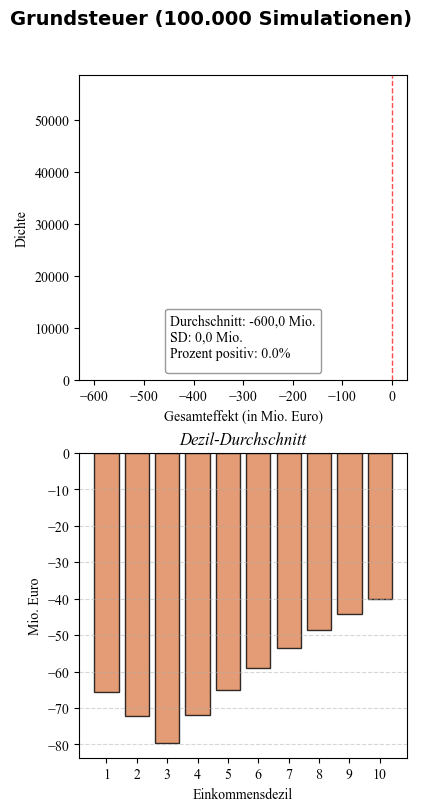

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(pt_tax, labels=[""], title=f"Grundsteuer ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

### 9.1.2. Varianten Grunderwerbsteuer (2 Diagramme)

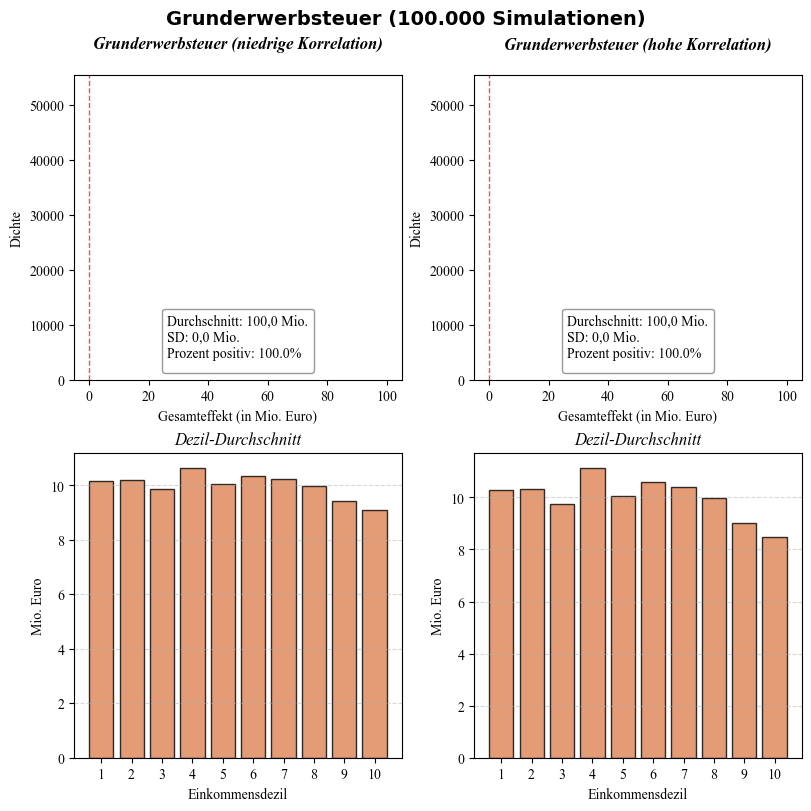

In [21]:
with plt.style.context("default"):
    fig = plot_reform_effects(rett_tax_low, rett_tax_high, labels=["Grunderwerbsteuer (niedrige Korrelation)", "Grunderwerbsteuer (hohe Korrelation)"], title=f"Grunderwerbsteuer ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

### 9.1.3. Varianten Gewerbesteuer (3 Diagramme)

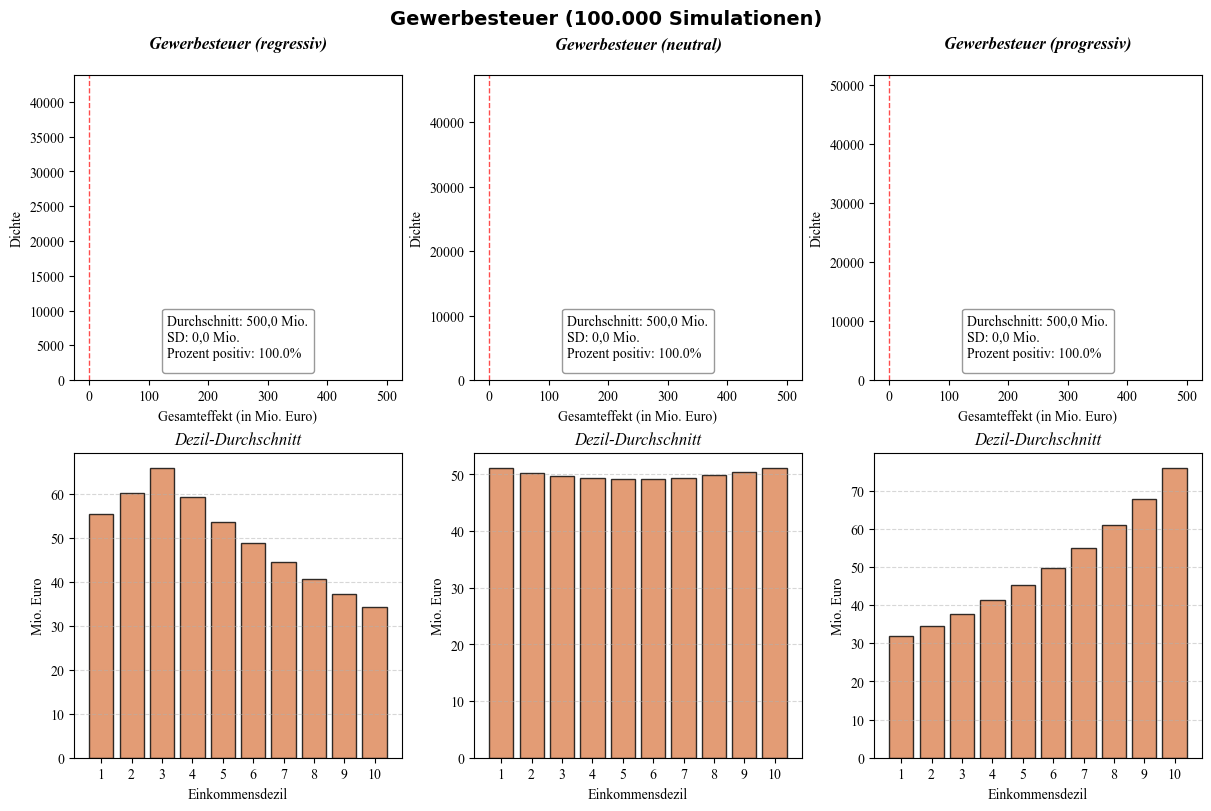

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(lbt_tax_inverse_pt, lbt_tax_neutral, lbt_tax_progressive, labels=["Gewerbesteuer (regressiv)", "Gewerbesteuer (neutral)", "Gewerbesteuer (progressiv)"], title=f"Gewerbesteuer ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

### 9.1.4. Gesamtverteilung der Steuern zusammen in allen Varianten (2 mal 3 Diagramme)

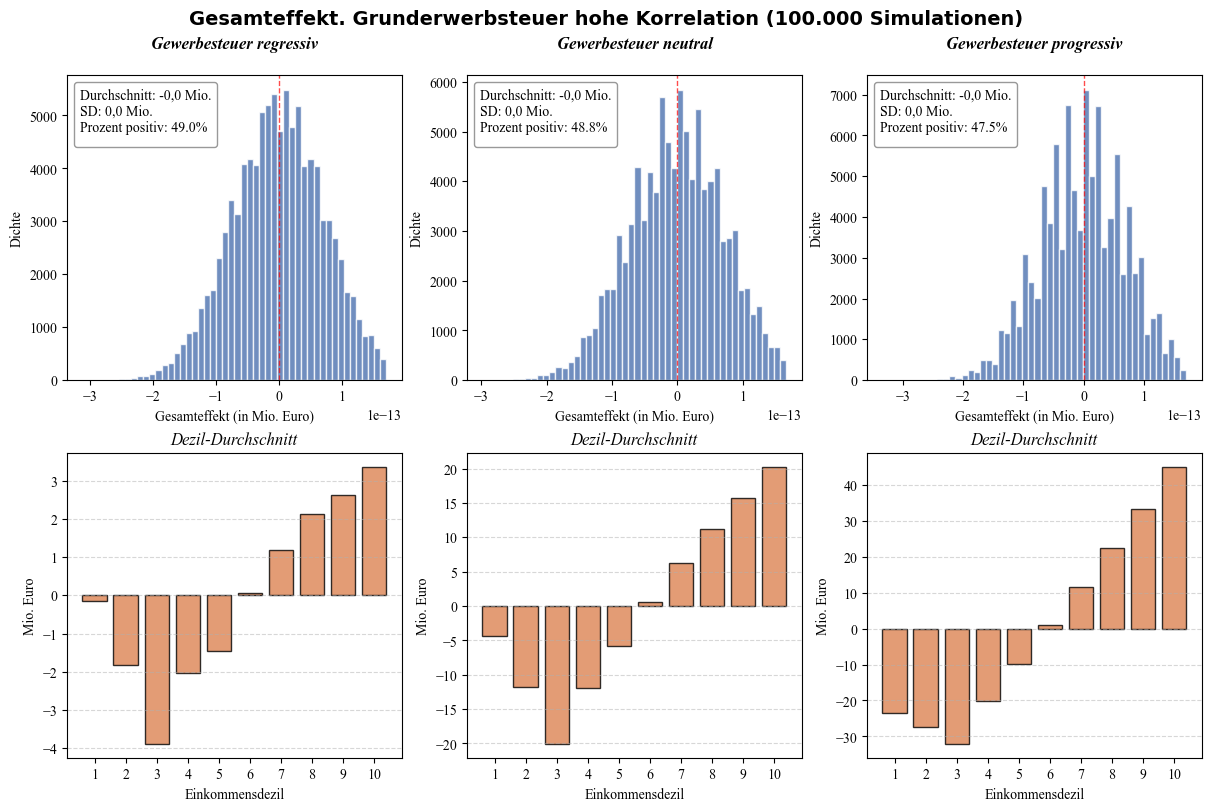

In [ ]:
pt_rett_sum_low = pt_tax + rett_tax_low

with plt.style.context("default"):
    fig = plot_reform_effects(pt_rett_sum_low + lbt_tax_inverse_pt, pt_rett_sum_low + lbt_tax_neutral, pt_rett_sum_low + lbt_tax_progressive, labels=["Gewerbesteuer regressiv", "Gewerbesteuer neutral", "Gewerbesteuer progressiv"], title=f"Gesamteffekt, Grunderwerbsteuer hohe Korrelation ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

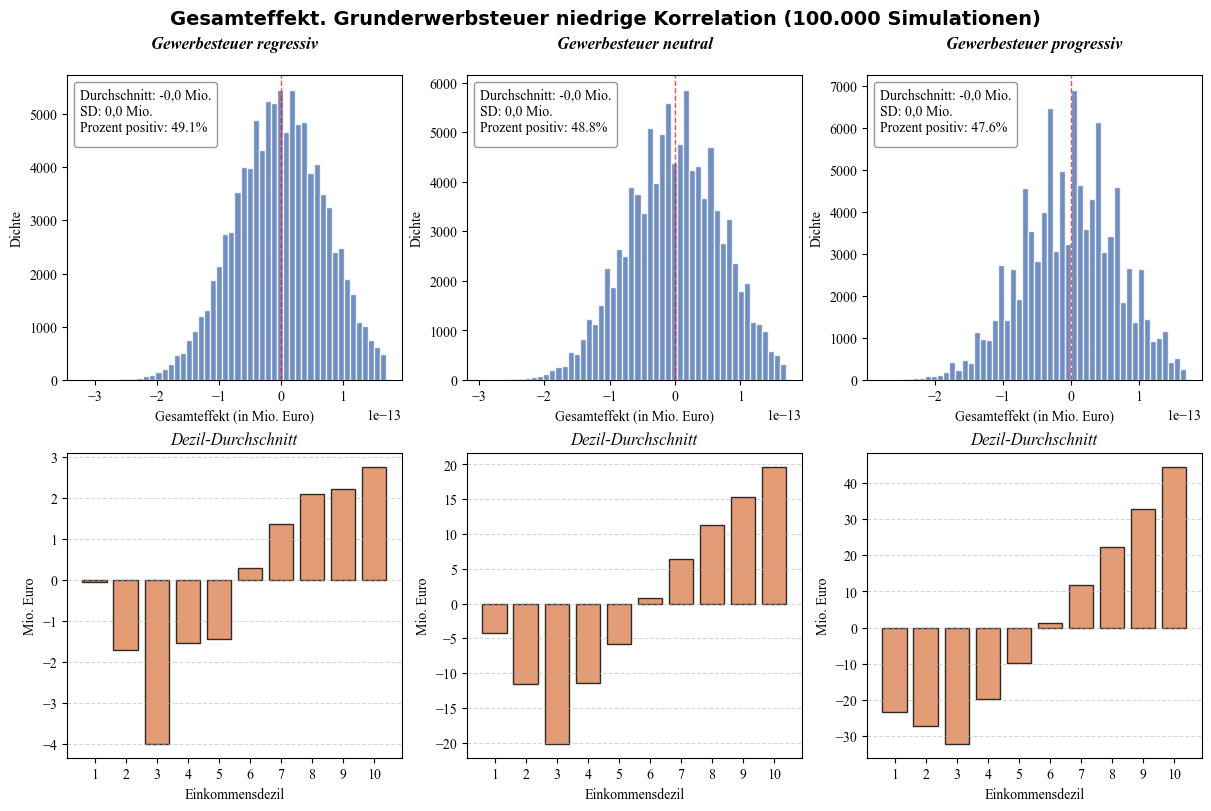

In [24]:
pt_rett_sum_high = pt_tax + rett_tax_high

with plt.style.context("default"):
    fig = plot_reform_effects(pt_rett_sum_high + lbt_tax_inverse_pt, pt_rett_sum_high + lbt_tax_neutral, pt_rett_sum_high + lbt_tax_progressive, labels=["Gewerbesteuer regressiv", "Gewerbesteuer neutral", "Gewerbesteuer progressiv"], title=f"Gesamteffekt, Grunderwerbsteuer niedrige Korrelation ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

### 9.1.5. Gewichtete Verteilungen der Gesamteffekte für präferiertes, pessimistisches, optimistisches Szenario (3 mal 3 Diagramme)

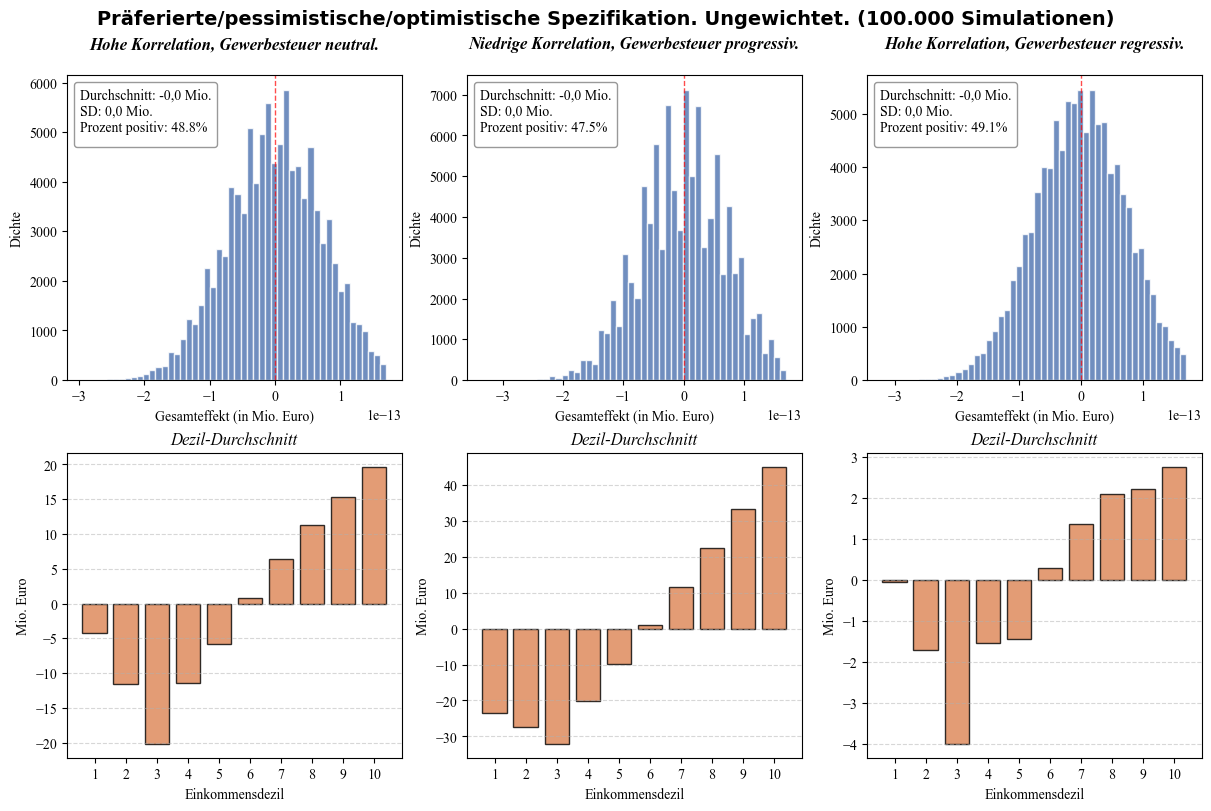

In [25]:
preferred = [pt_tax, rett_tax_high, lbt_tax_neutral]
pessimistic = [pt_tax, rett_tax_low, lbt_tax_progressive]
optimistic = [pt_tax, rett_tax_high, lbt_tax_inverse_pt]

with plt.style.context("default"):
    fig = plot_reform_effects(sum(preferred), sum(pessimistic), sum(optimistic), labels=["Hohe Korrelation, Gewerbesteuer neutral.", "Niedrige Korrelation, Gewerbesteuer progressiv.", "Hohe Korrelation, Gewerbesteuer regressiv."], title=f"Präferierte/pessimistische/optimistische Spezifikation. Ungewichtet. ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

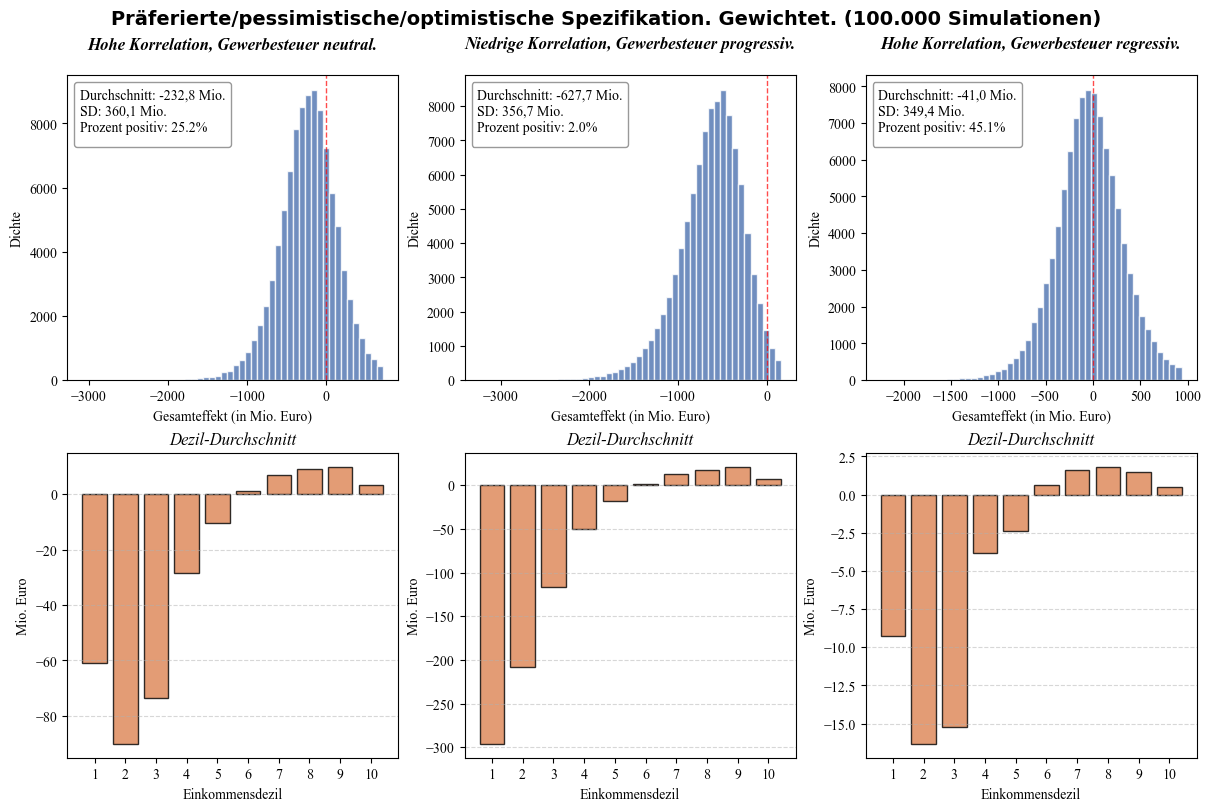

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(sum(preferred) * decile_weights, sum(pessimistic) * decile_weights, sum(optimistic) * decile_weights, labels=["Hohe Korrelation, Gewerbesteuer neutral.", "Niedrige Korrelation, Gewerbesteuer progressiv.", "Hohe Korrelation, Gewerbesteuer regressiv."], title=f"Präferierte/pessimistische/optimistische Spezifikation. Gewichtet. ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

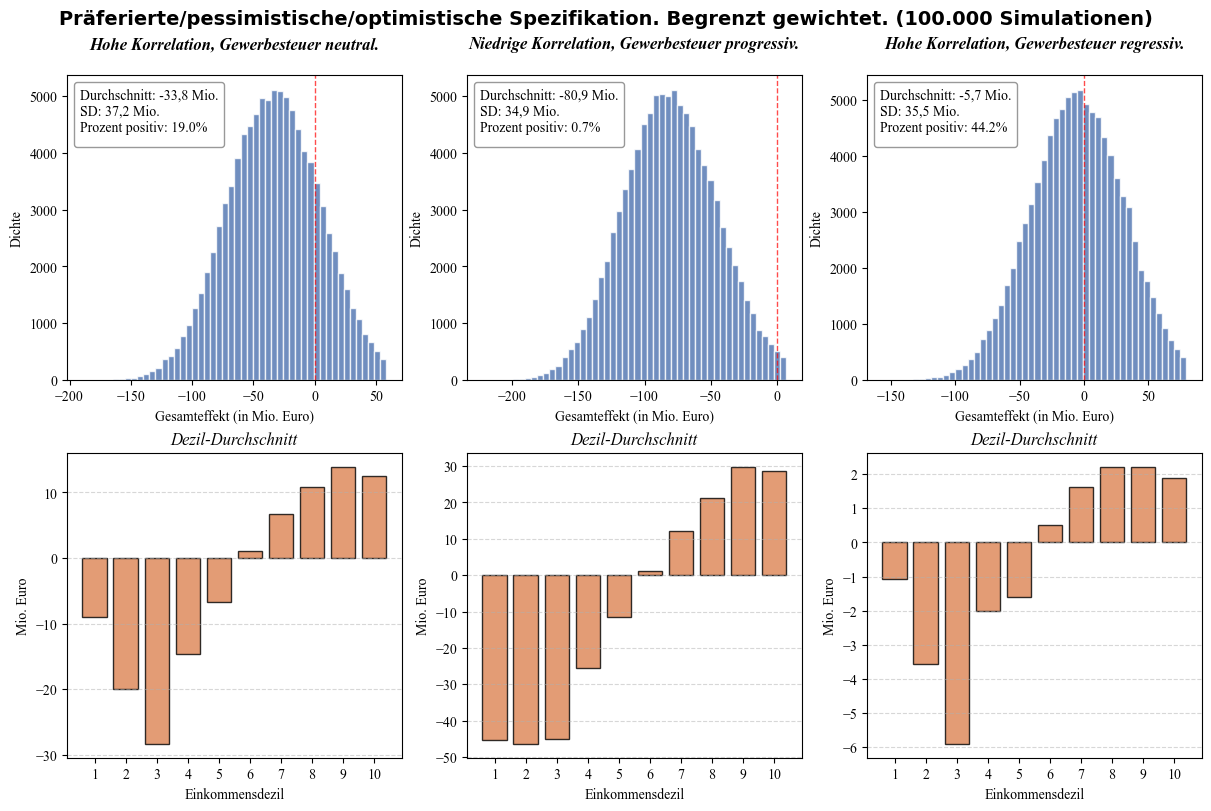

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(sum(preferred) * capped_decile_weights, sum(pessimistic) * capped_decile_weights, sum(optimistic) * capped_decile_weights, labels=["Hohe Korrelation, Gewerbesteuer neutral.", "Niedrige Korrelation, Gewerbesteuer progressiv.", "Hohe Korrelation, Gewerbesteuer regressiv."], title=f"Präferierte/pessimistische/optimistische Spezifikation. Begrenzt gewichtet. ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

## 9.2. DWL-Effekte

### 9.2.1. Grundsteuer DWL

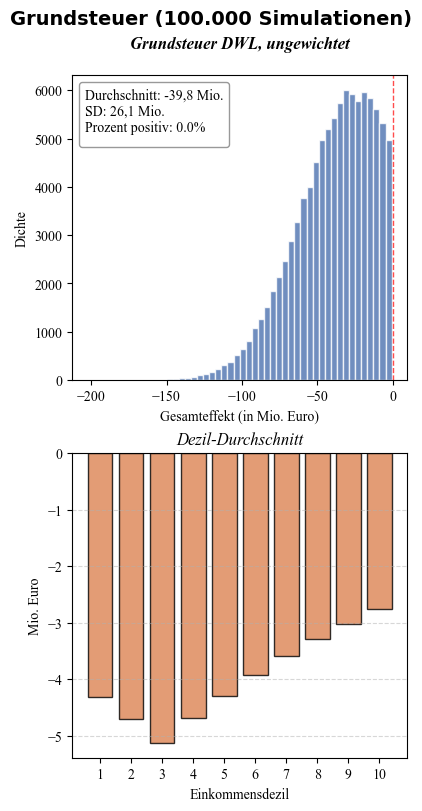

In [28]:
with plt.style.context("default"):
    fig = plot_reform_effects(pt_DWL, labels=["Grundsteuer DWL, ungewichtet"], title=f"Grundsteuer ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

### 9.2.2. Grunderwerbsteuer DWL in zwei Varianten

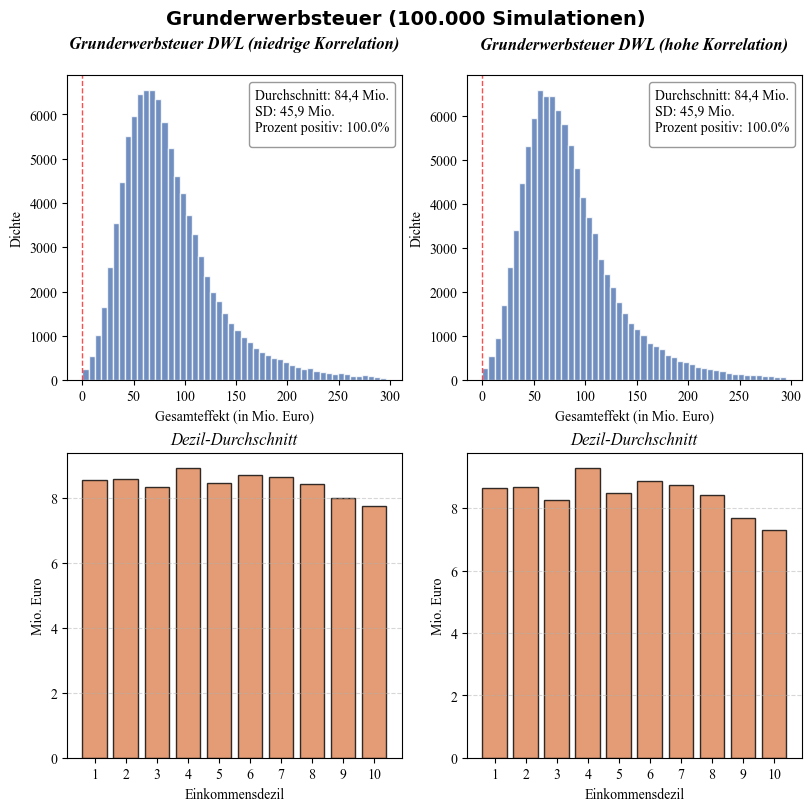

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(rett_DWL_low, rett_DWL_high, labels=["Grunderwerbsteuer DWL (niedrige Korrelation)", "Grunderwerbsteuer DWL (hohe Korrelation)"], title=f"Grunderwerbsteuer ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

### 9.2.3. Gewerbesteuer DWL in drei Varianten

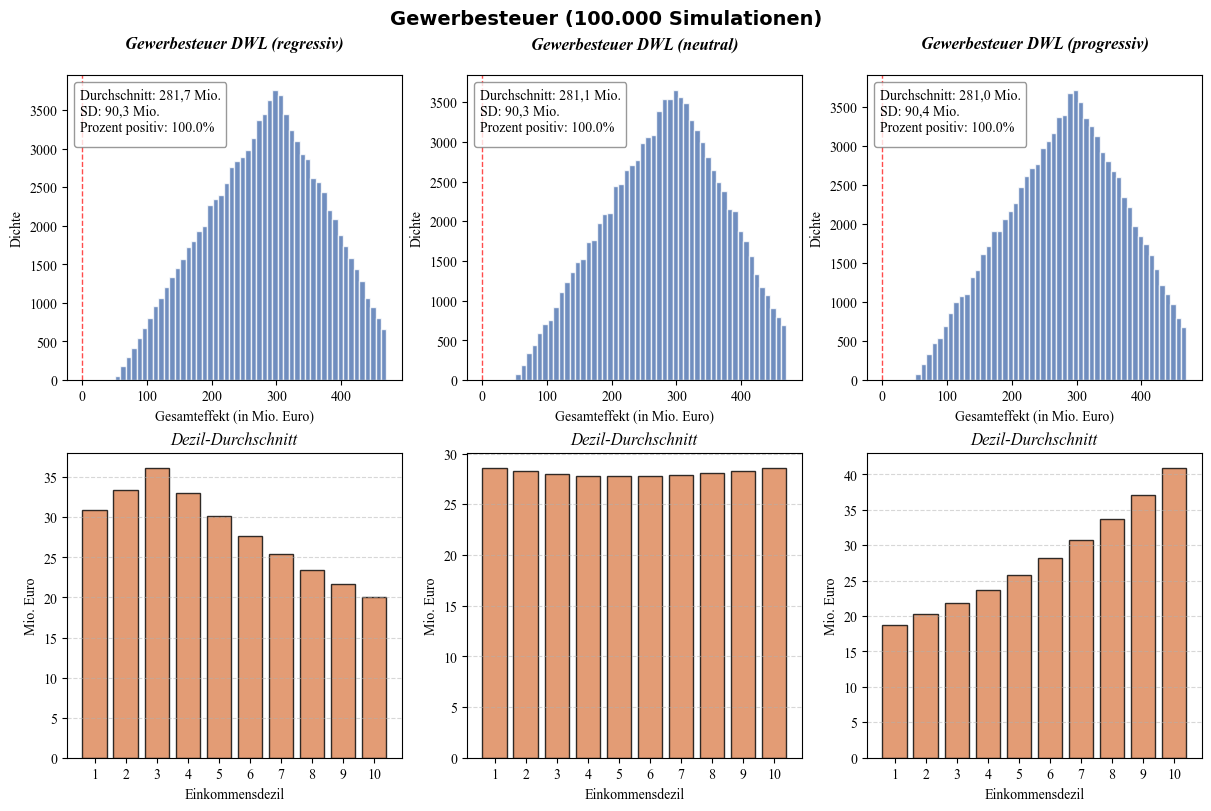

In [30]:
with plt.style.context("default"):
    fig = plot_reform_effects(lbt_DWL_inverse_pt, lbt_DWL_neutral, lbt_DWL_progressive, labels=["Gewerbesteuer DWL (regressiv)", "Gewerbesteuer DWL (neutral)", "Gewerbesteuer DWL (progressiv)"], title=f"Gewerbesteuer ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

### 9.2.4. Gesamtverteilung DWL zusammen in allen Varianten

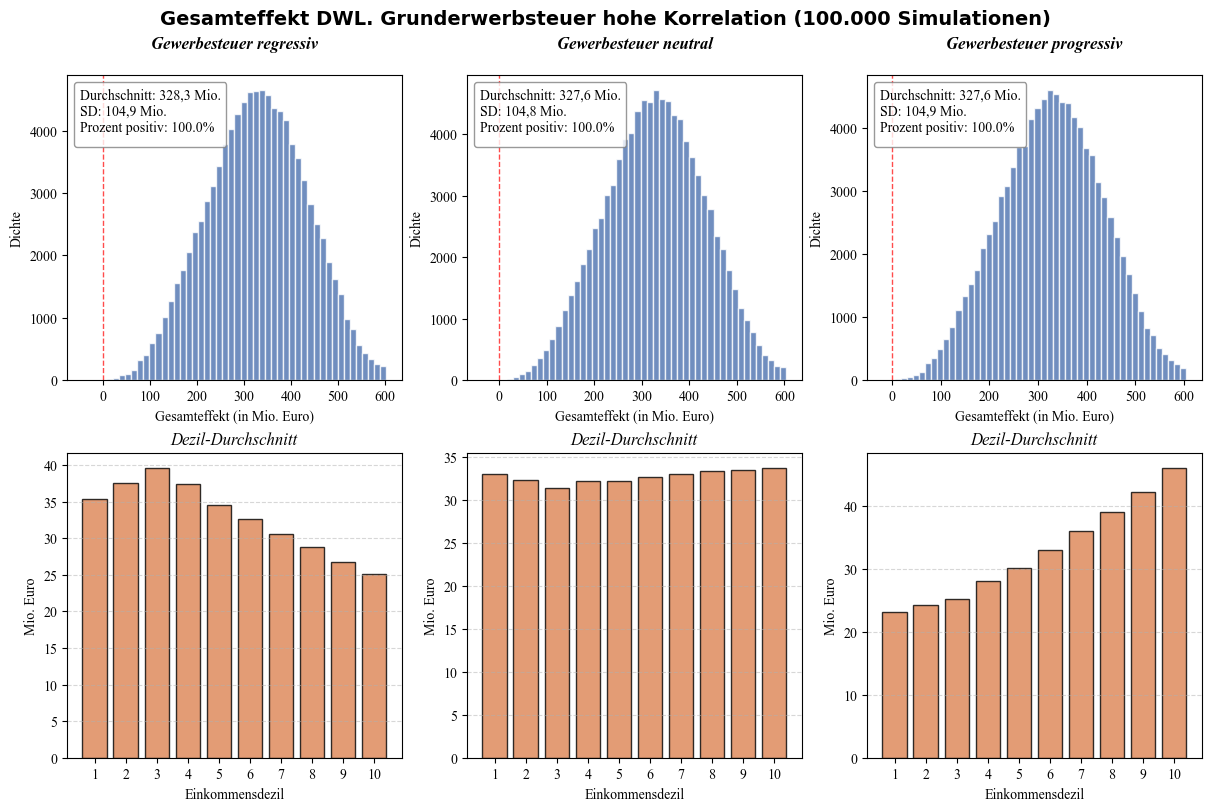

In [102]:
pt_rett_DWL_sum_low = pt_DWL + rett_DWL_low

with plt.style.context("default"):
    fig = plot_reform_effects(pt_rett_DWL_sum_low + lbt_DWL_inverse_pt, pt_rett_DWL_sum_low + lbt_DWL_neutral, pt_rett_DWL_sum_low + lbt_DWL_progressive, labels=["Gewerbesteuer regressiv", "Gewerbesteuer neutral", "Gewerbesteuer progressiv"], title=f"Gesamteffekt DWL, Grunderwerbsteuer hohe Korrelation ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

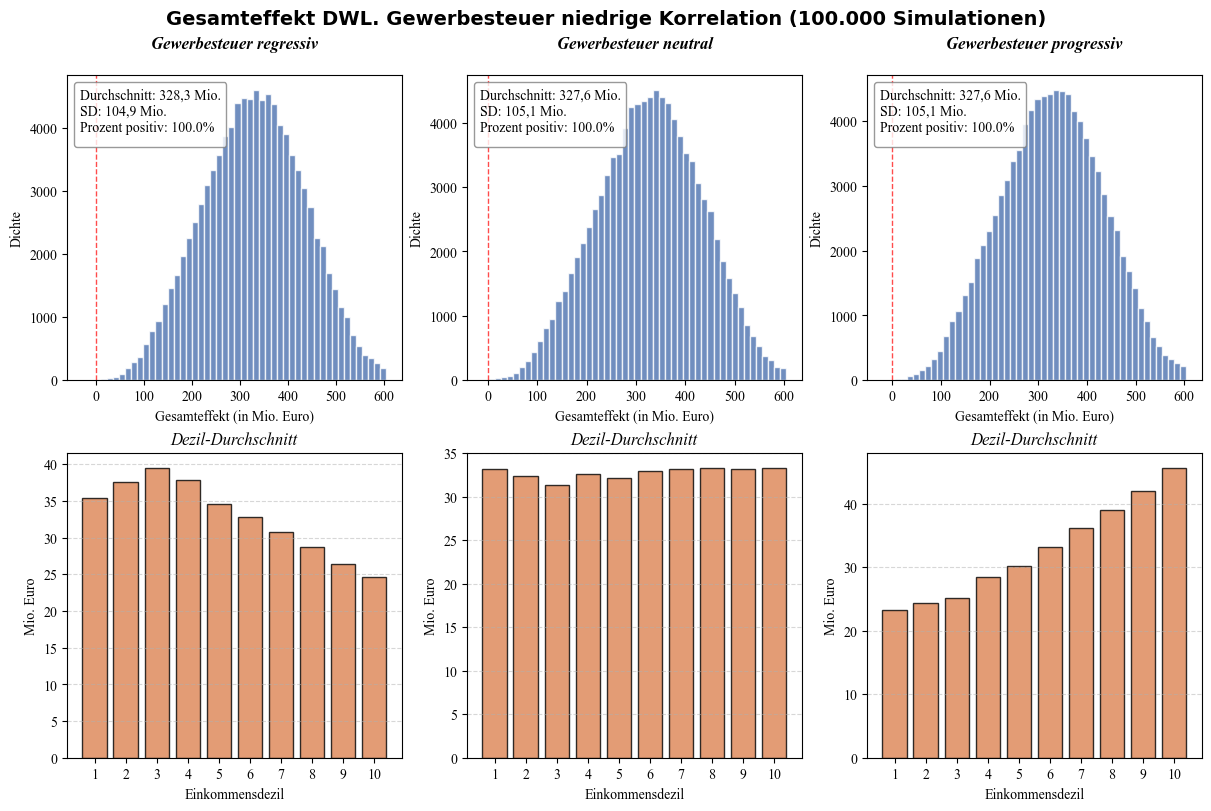

In [103]:
pt_rett_sum_DWL_high = pt_DWL + rett_DWL_high

with plt.style.context("default"):
    fig = plot_reform_effects(pt_rett_sum_DWL_high + lbt_DWL_inverse_pt, pt_rett_sum_DWL_high + lbt_DWL_neutral, pt_rett_sum_DWL_high + lbt_DWL_progressive, labels=["Gewerbesteuer regressiv", "Gewerbesteuer neutral", "Gewerbesteuer progressiv"], title=f"Gesamteffekt DWL, Gewerbesteuer niedrige Korrelation ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

### 9.2.5. Gewichtete Verteilungen der Gesamteffekte DWL für die drei Szenarien

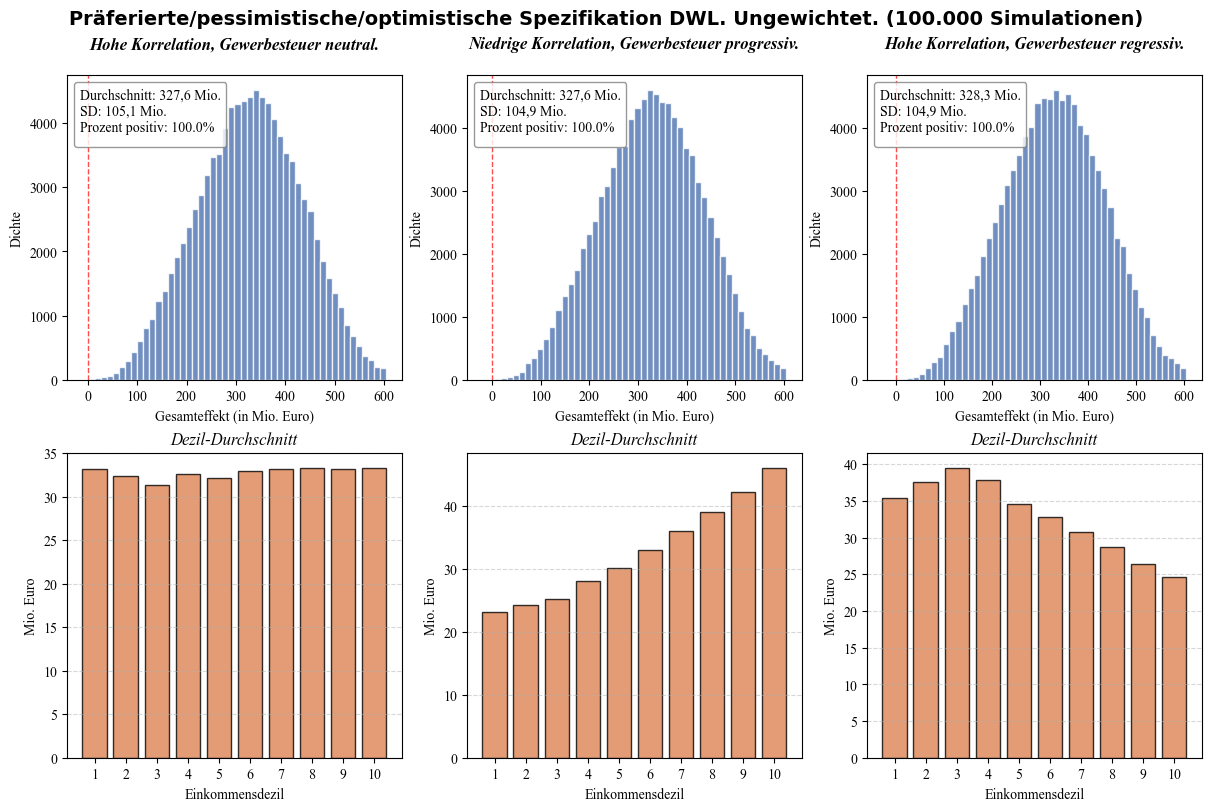

In [ ]:
preferred_DWL = [pt_DWL, rett_DWL_high, lbt_DWL_neutral]
pessimistic_DWL = [pt_DWL, rett_DWL_low, lbt_DWL_progressive]
optimistic_DWL = [pt_DWL, rett_DWL_high, lbt_DWL_inverse_pt]

with plt.style.context("default"):
    fig = plot_reform_effects(sum(preferred_DWL), sum(pessimistic_DWL), sum(optimistic_DWL), labels=["Hohe Korrelation, Gewerbesteuer neutral.", "Niedrige Korrelation, Gewerbesteuer progressiv.", "Hohe Korrelation, Gewerbesteuer regressiv."], title=f"Präferierte/pessimistische/optimistische Spezifikation DWL. Ungewichtet. ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

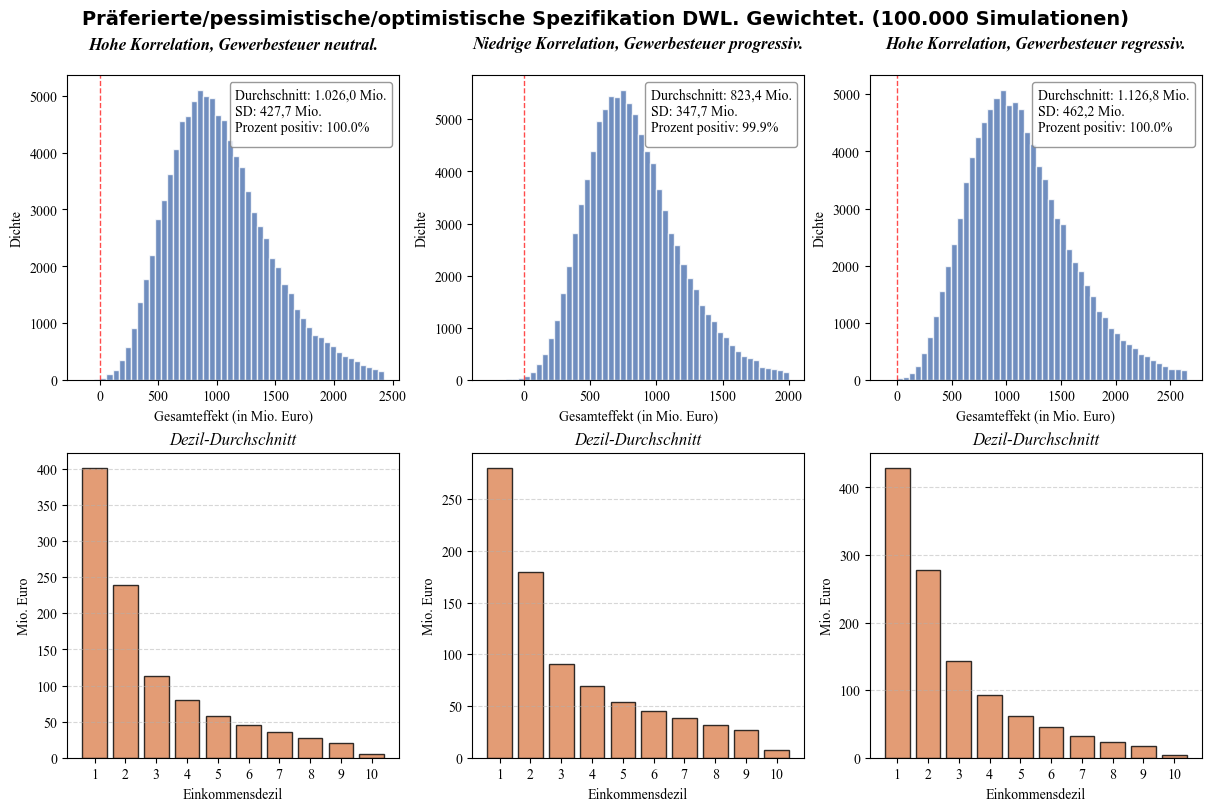

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(sum(preferred_DWL) * decile_weights, sum(pessimistic_DWL) * decile_weights, sum(optimistic_DWL) * decile_weights, labels=["Hohe Korrelation, Gewerbesteuer neutral.", "Niedrige Korrelation, Gewerbesteuer progressiv.", "Hohe Korrelation, Gewerbesteuer regressiv."], title=f"Präferierte/pessimistische/optimistische Spezifikation DWL. Gewichtet. ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

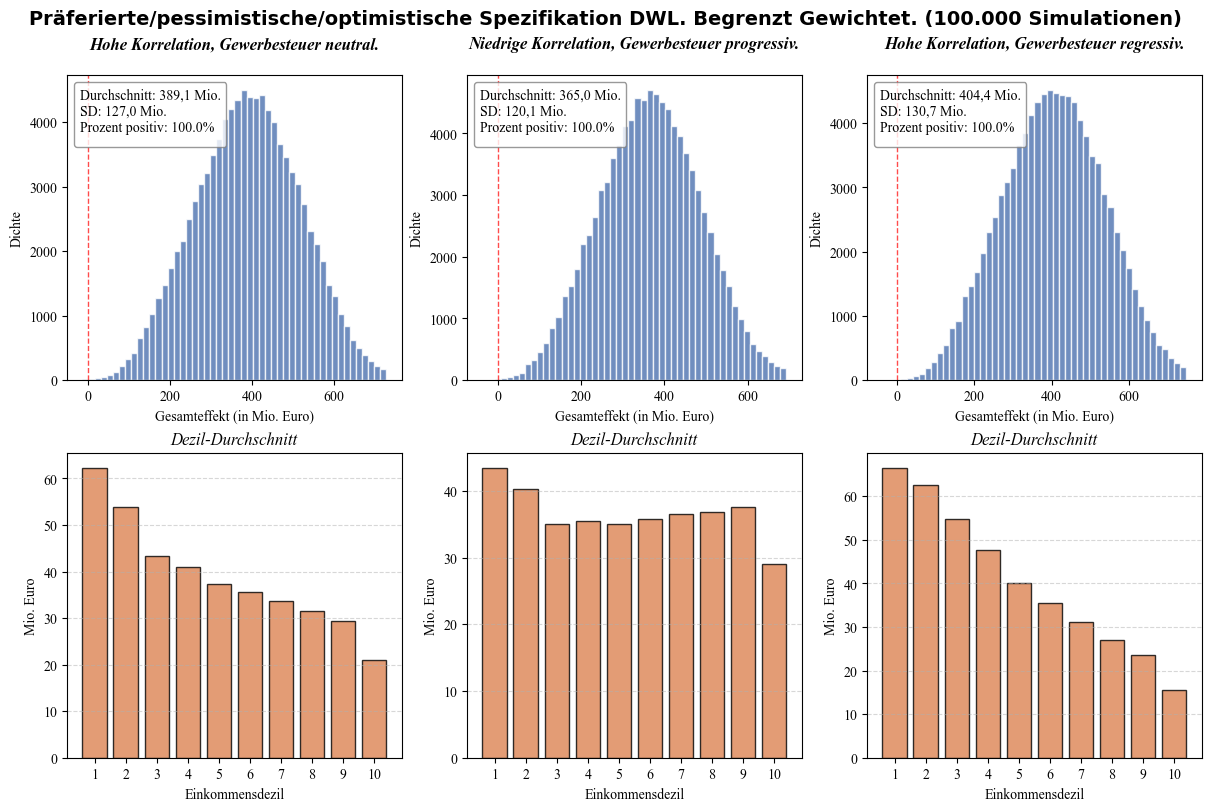

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(sum(preferred_DWL) * capped_decile_weights, sum(pessimistic_DWL) * capped_decile_weights, sum(optimistic_DWL) * capped_decile_weights, labels=["Hohe Korrelation, Gewerbesteuer neutral.", "Niedrige Korrelation, Gewerbesteuer progressiv.", "Hohe Korrelation, Gewerbesteuer regressiv."], title=f"Präferierte/pessimistische/optimistische Spezifikation DWL. Begrenzt Gewichtet. ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

## 9.3 Wachstums-Effekte

### 9.3.1. 3 Jahre in drei Gewichtungen

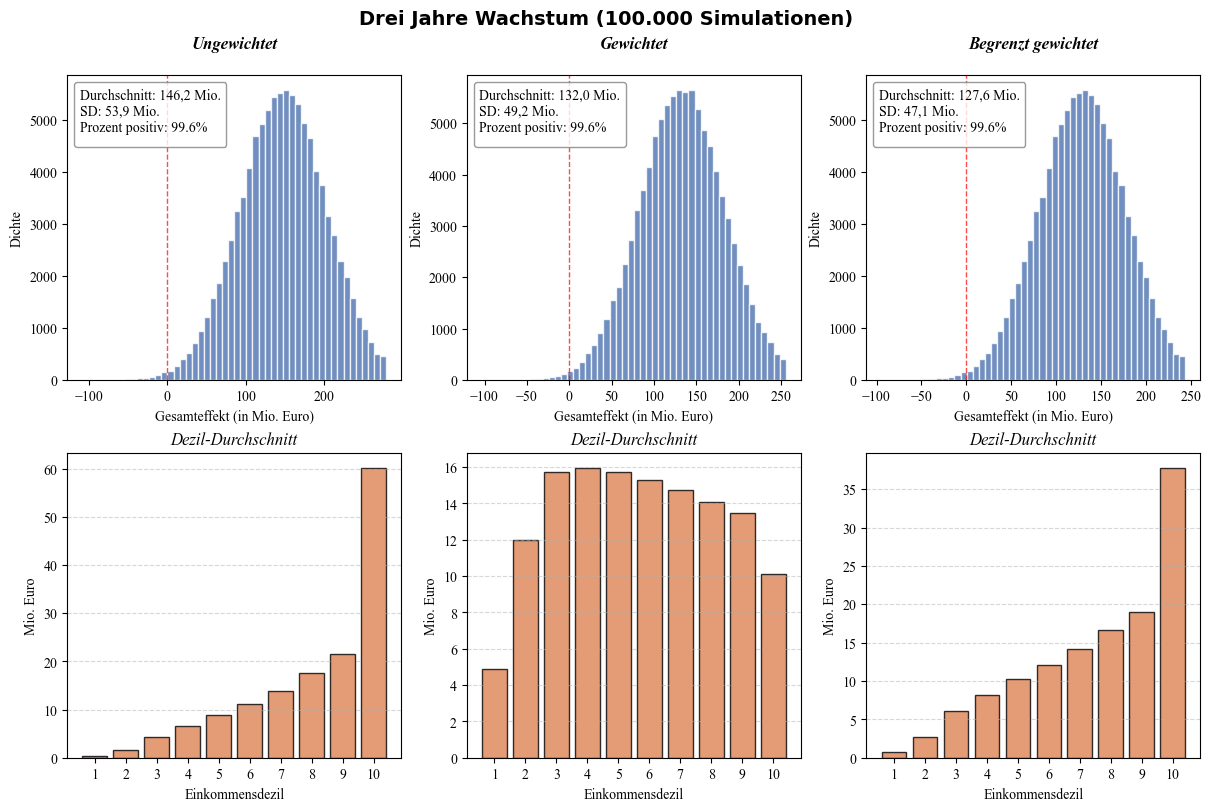

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(growth_3, growth_3 * decile_weights, growth_3 * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Drei Jahre Wachstum ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

### 9.3.2. 6 Jahre in drei Gewichtungen

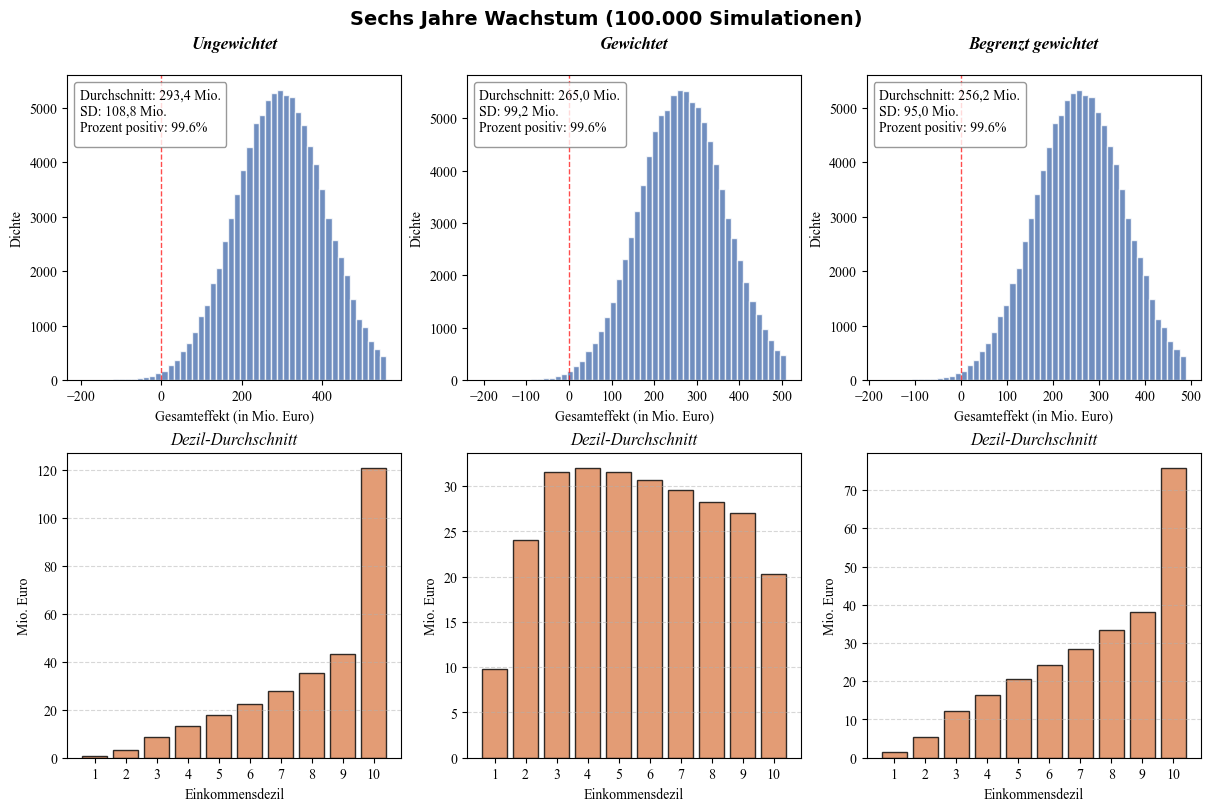

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(growth_6, growth_6 * decile_weights, growth_6 * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Sechs Jahre Wachstum ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

### 9.3.3. 10 Jahre in drei Gewichtungen

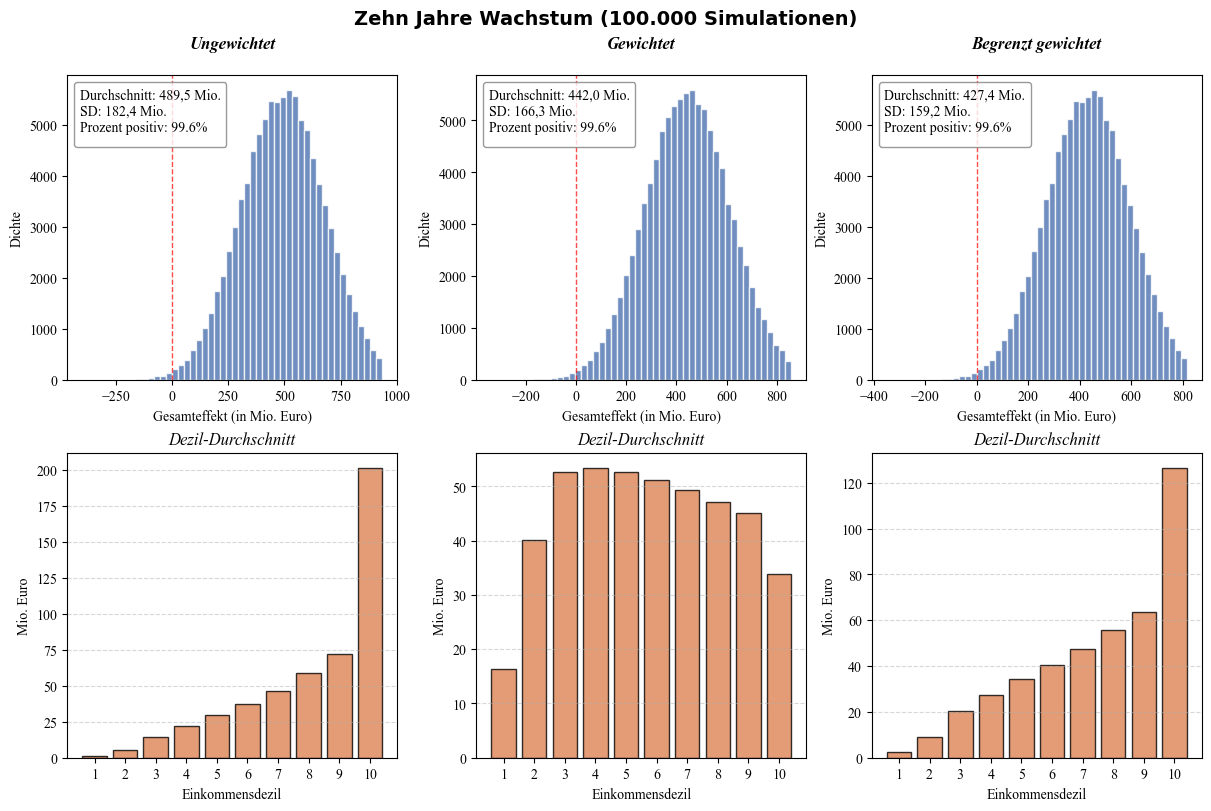

In [ ]:
with plt.style.context("default"):
    fig = plot_reform_effects(growth_10, growth_10 * decile_weights, growth_10 * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Zehn Jahre Wachstum ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()

## 9.4 Gesamteffekte

### 9.4.1. Präferiertes Szenario in drei Gewichtungen

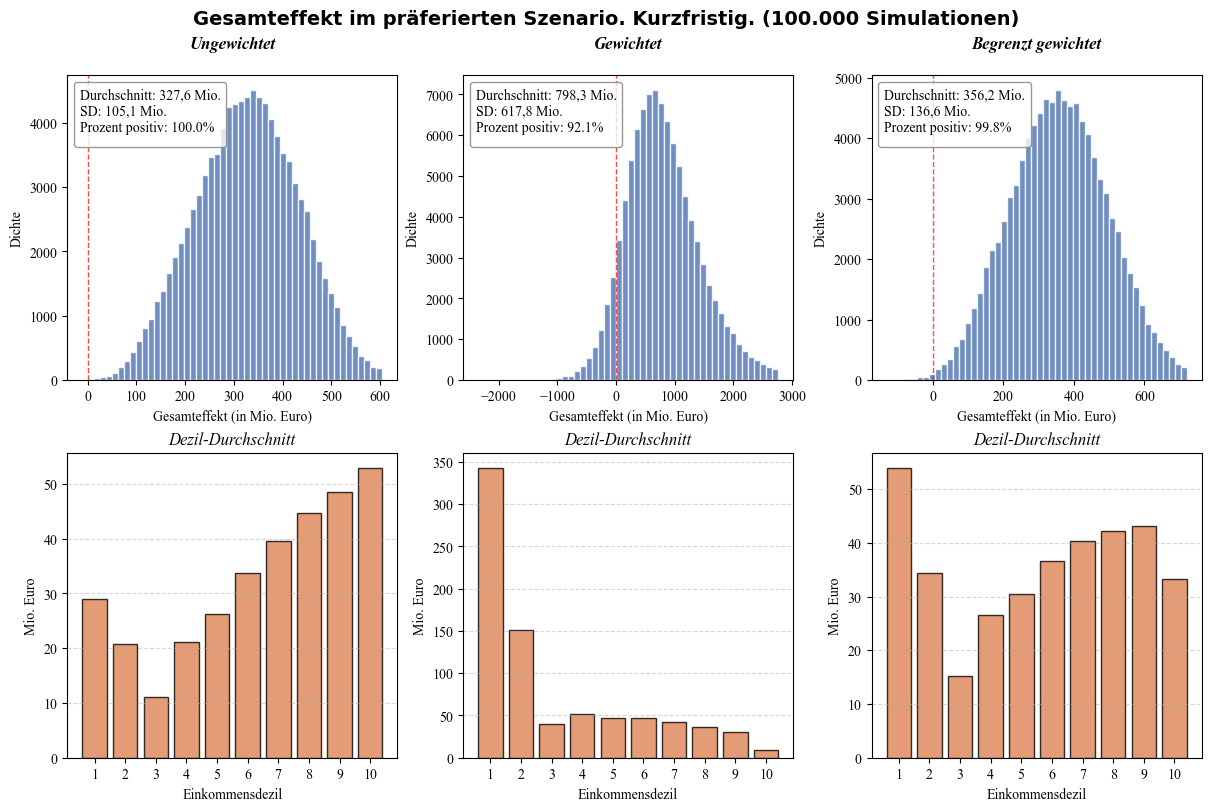

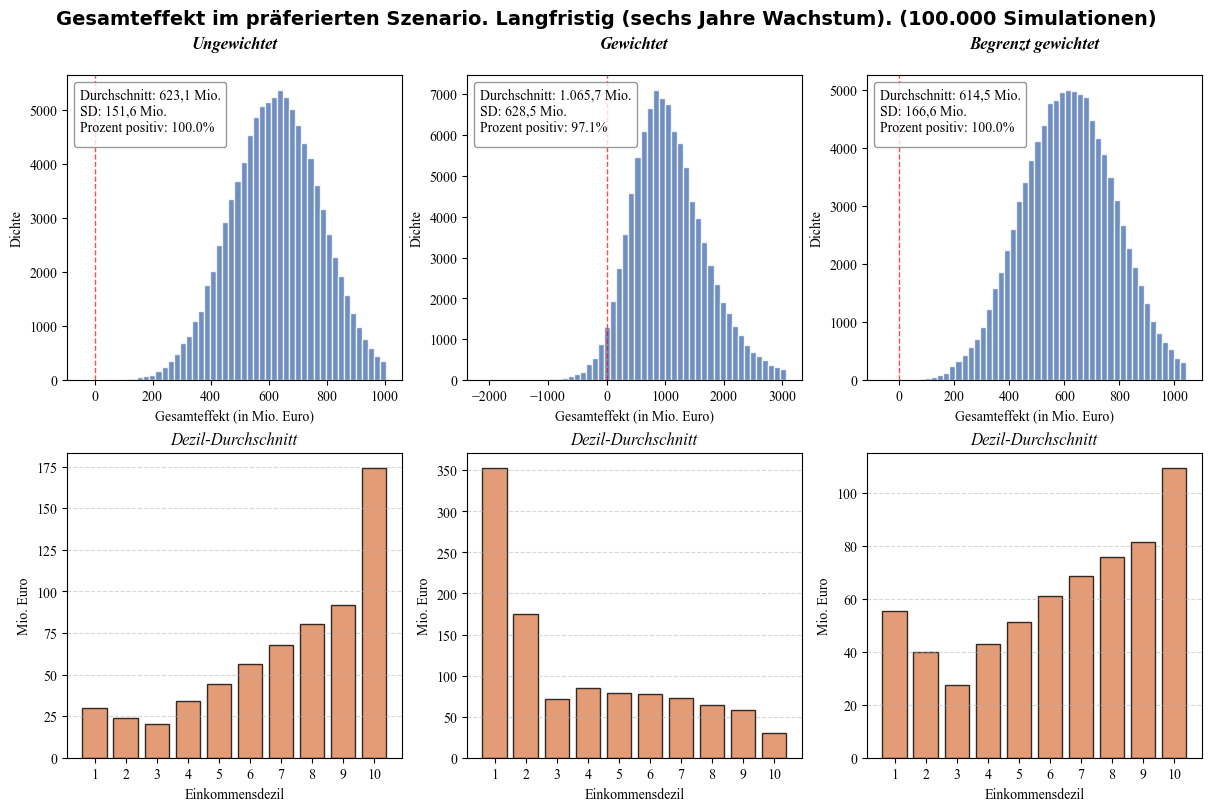

In [ ]:
preferred_total_shortrun = [pt_tax, pt_DWL, rett_tax_high, rett_DWL_high, lbt_tax_neutral, lbt_DWL_neutral]
preferred_total_longrun = [pt_tax, pt_DWL, rett_tax_high, rett_DWL_high, lbt_tax_neutral, lbt_DWL_neutral, growth_6]

with plt.style.context("default"):
    fig = plot_reform_effects(sum(preferred_total_shortrun), sum(preferred_total_shortrun) * decile_weights, sum(preferred_total_shortrun) * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Gesamteffekt im präferierten Szenario. Kurzfristig. ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()
    fig = plot_reform_effects(sum(preferred_total_longrun), sum(preferred_total_longrun) * decile_weights, sum(preferred_total_longrun) * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Gesamteffekt im präferierten Szenario. Langfristig (sechs Jahre Wachstum). ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

### 9.4.2. Pessimistisches Szenario in drei Gewichtungen

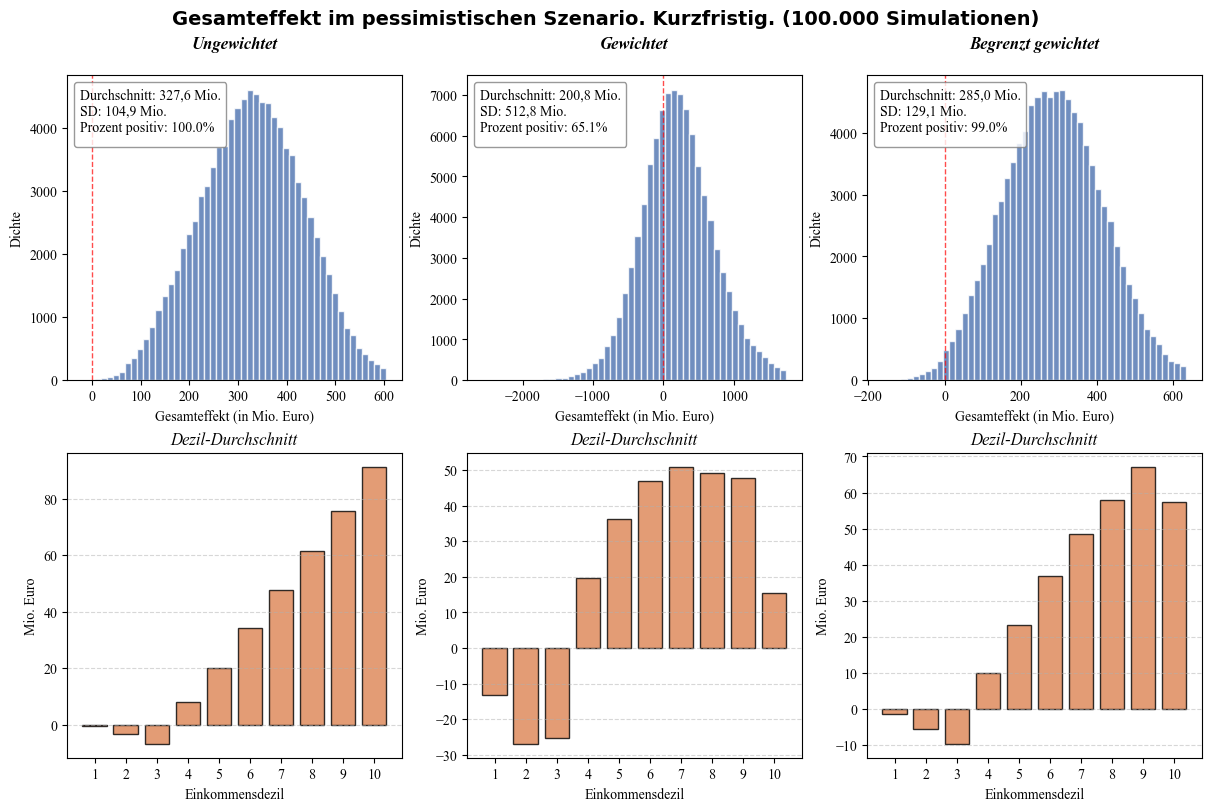

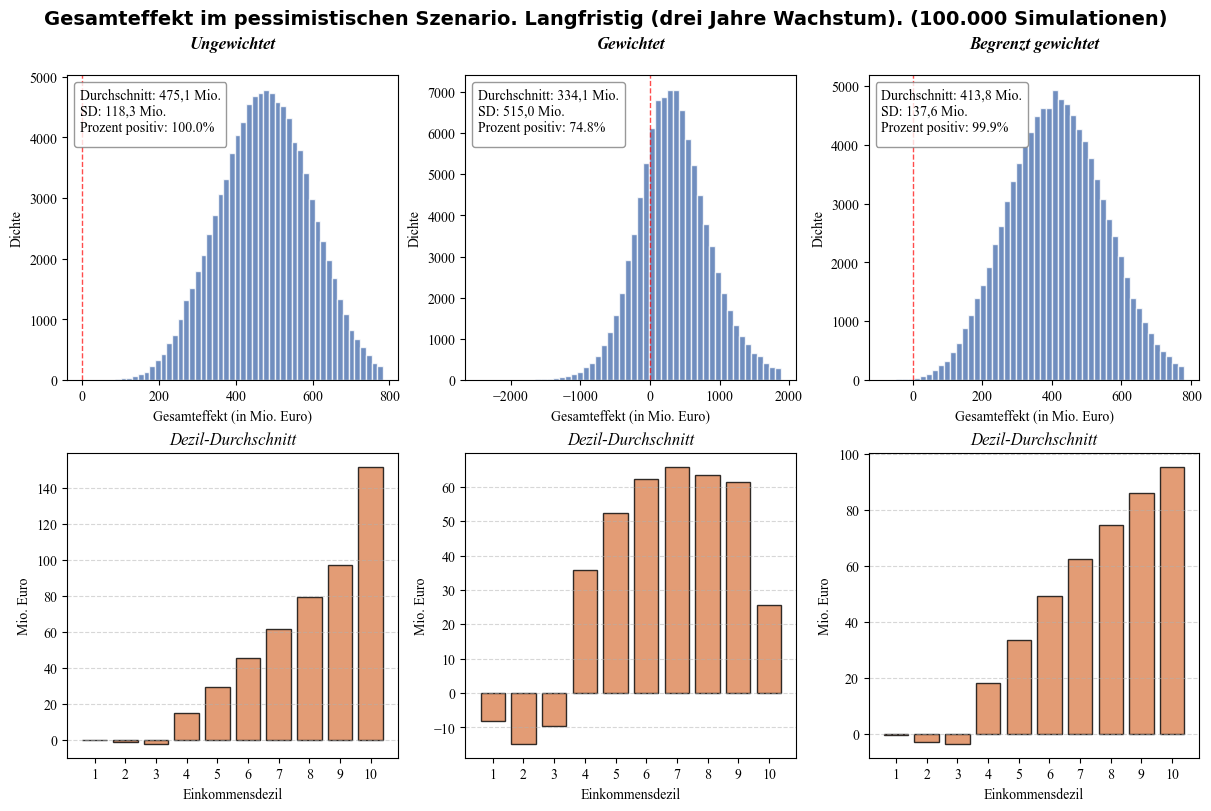

In [ ]:
pessimistic_total_shortrun = [pt_tax, pt_DWL, rett_tax_low, rett_DWL_low, lbt_tax_progressive, lbt_DWL_progressive]
pessimistic_total_longrun = [pt_tax, pt_DWL, rett_tax_low, rett_DWL_low, lbt_tax_progressive, lbt_DWL_progressive, growth_3]

with plt.style.context("default"):
    fig = plot_reform_effects(sum(pessimistic_total_shortrun), sum(pessimistic_total_shortrun) * decile_weights, sum(pessimistic_total_shortrun) * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Gesamteffekt im pessimistischen Szenario. Kurzfristig. ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()
    fig = plot_reform_effects(sum(pessimistic_total_longrun), sum(pessimistic_total_longrun) * decile_weights, sum(pessimistic_total_longrun) * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Gesamteffekt im pessimistischen Szenario. Langfristig (drei Jahre Wachstum). ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()

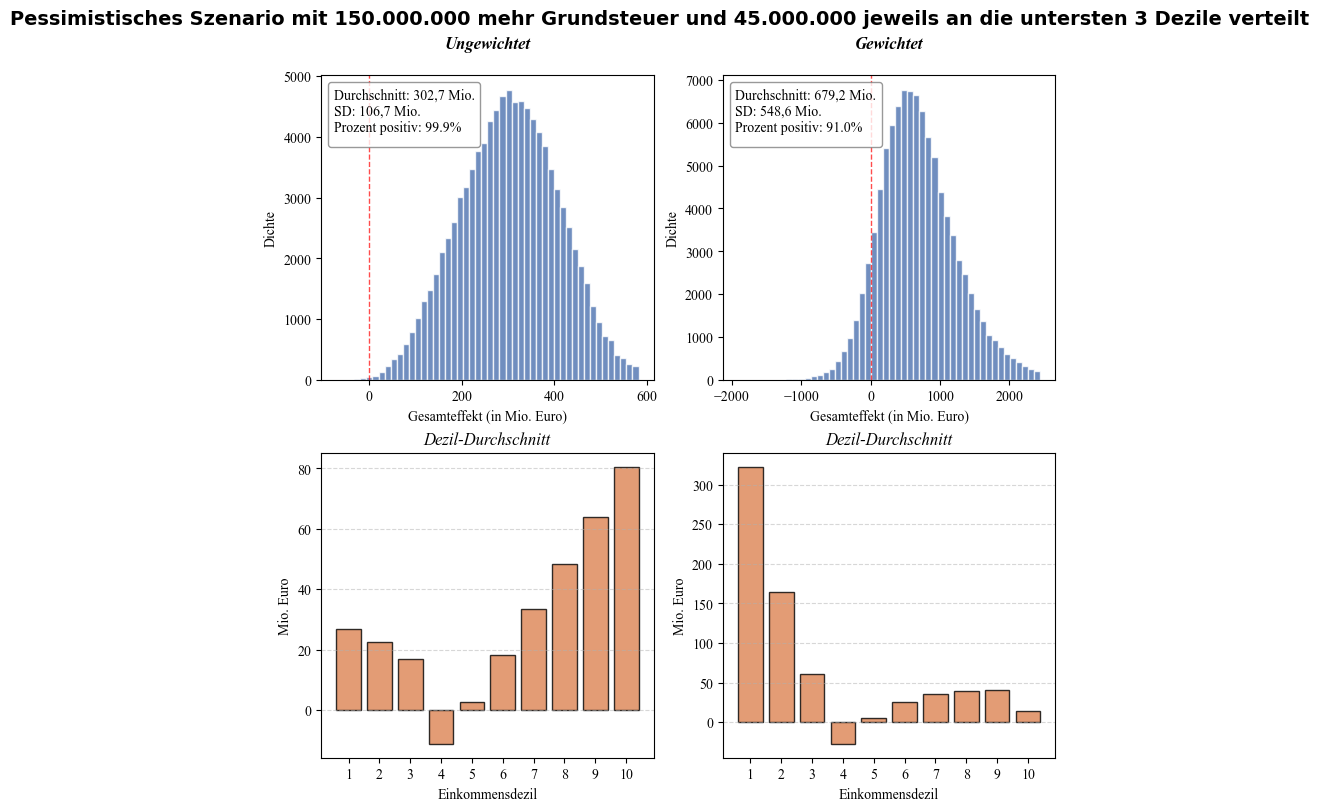

<Figure size 640x480 with 0 Axes>

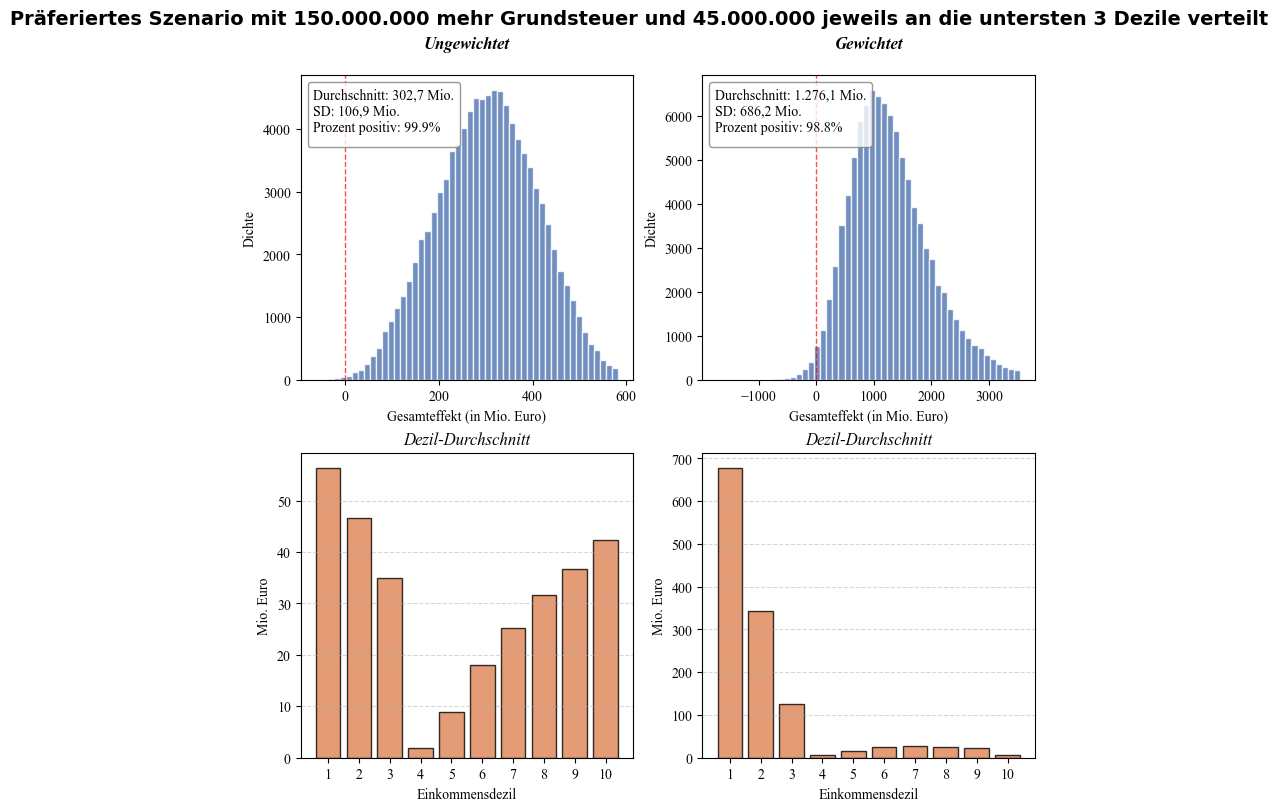

In [ ]:
factor = 1.25
num_divisions = 3
more_taxes = (pt_change * factor - pt_change)
redistribution_amount = (more_taxes * 0.9)/num_divisions

pt_tax_redistribution, pt_DWL_redistribution = pt_tax * factor, pt_DWL * factor
temp = np.zeros((num_sim, 10))
temp[:, 0:num_divisions] -= redistribution_amount

pessimistic_with_redistribution_shortrun = sum([pt_tax_redistribution, pt_DWL_redistribution, rett_tax_low, rett_DWL_low, lbt_tax_progressive, lbt_DWL_progressive, temp])
preferred_with_redistribution_shortrun = sum([pt_tax_redistribution, pt_DWL_redistribution, rett_tax_high, rett_DWL_high, lbt_tax_neutral, lbt_DWL_neutral, temp])

with plt.style.context("default"):
    fig = plot_reform_effects(pessimistic_with_redistribution_shortrun, pessimistic_with_redistribution_shortrun * decile_weights, labels=["Ungewichtet", "Gewichtet"], title=f"Pessimistisches Szenario mit {-more_taxes:,.0f} mehr Grundsteuer und {-redistribution_amount:,.0f} jeweils an die untersten {num_divisions} Dezile verteilt".replace(",", "."))
    plt.show()
    
    fig = plot_reform_effects(preferred_with_redistribution_shortrun, preferred_with_redistribution_shortrun * decile_weights, labels=["Ungewichtet", "Gewichtet"], title=f"Präferiertes Szenario mit {-more_taxes:,.0f} mehr Grundsteuer und {-redistribution_amount:,.0f} jeweils an die untersten {num_divisions} Dezile verteilt".replace(",", "."))
    plt.show()

### 9.4.3. Optimistisches Szenario in drei Gewichtungen

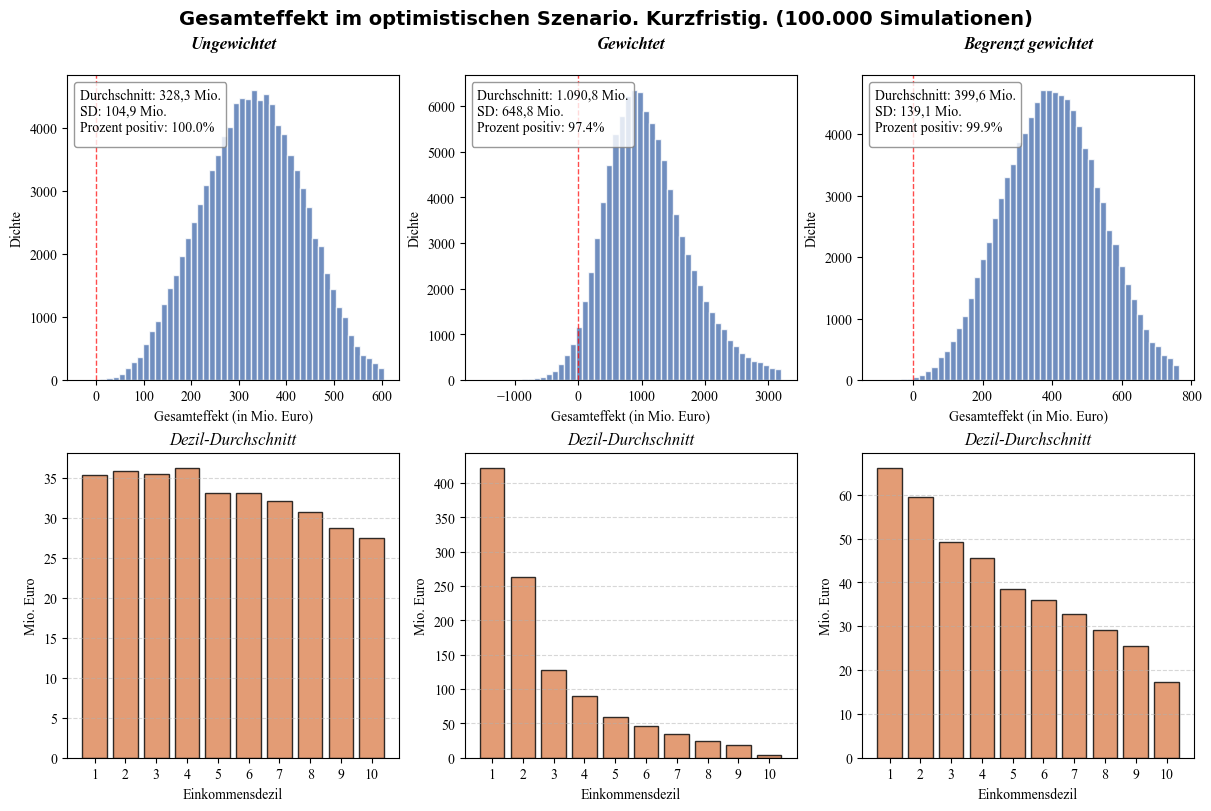

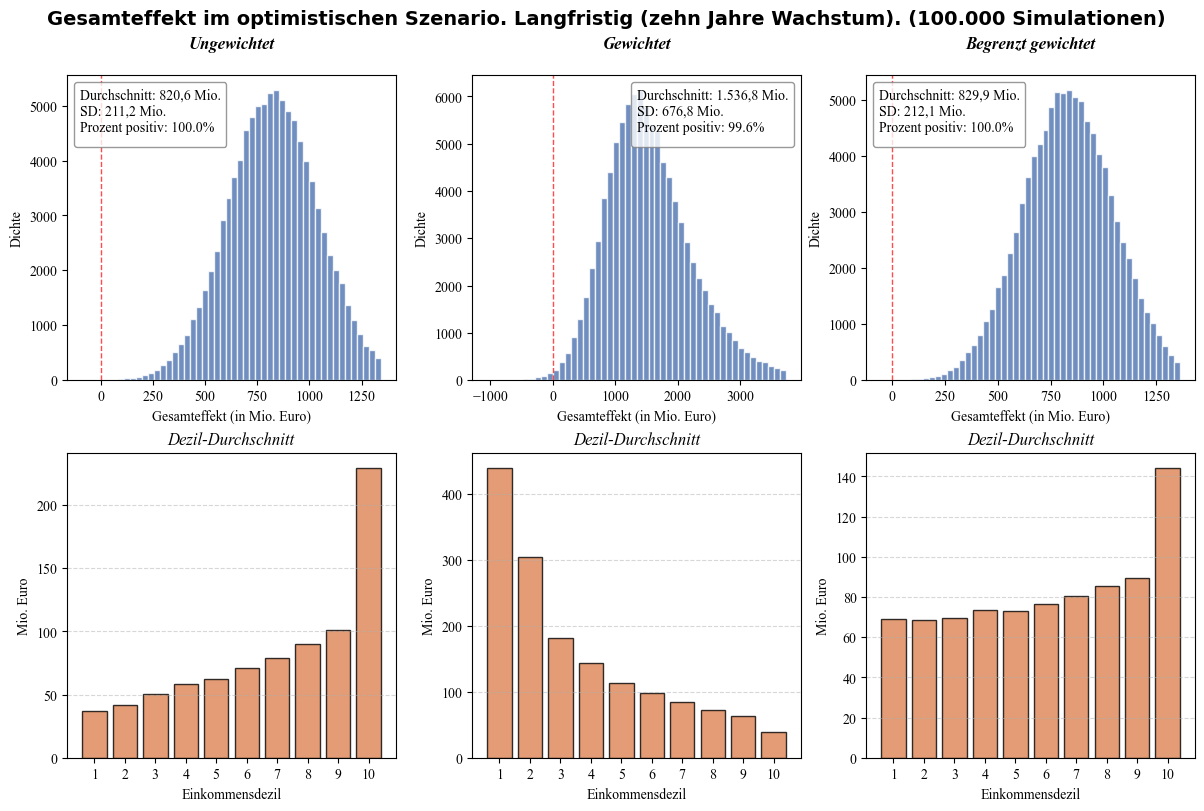

In [ ]:
optimistic_total_shortrun = [pt_tax, pt_DWL, rett_tax_high, rett_DWL_high, lbt_tax_inverse_pt, lbt_DWL_inverse_pt]
optimistic_total_longrun = [pt_tax, pt_DWL, rett_tax_high, rett_DWL_high, lbt_tax_inverse_pt, lbt_DWL_inverse_pt, growth_10]

with plt.style.context("default"):
    fig = plot_reform_effects(sum(optimistic_total_shortrun), sum(optimistic_total_shortrun) * decile_weights, sum(optimistic_total_shortrun) * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Gesamteffekt im optimistischen Szenario. Kurzfristig. ({num_sim:,} Simulationen)".replace(",", "."))
    
    plt.show()
    fig = plot_reform_effects(sum(optimistic_total_longrun), sum(optimistic_total_longrun) * decile_weights, sum(optimistic_total_longrun) * capped_decile_weights, labels=["Ungewichtet", "Gewichtet", "Begrenzt gewichtet"], title=f"Gesamteffekt im optimistischen Szenario. Langfristig (zehn Jahre Wachstum). ({num_sim:,} Simulationen)".replace(",", "."))

    plt.show()